In [2]:
! pip install emd

## Initializing and loading required libraries and subfunctions

In [3]:
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.interpolate import griddata
import copy
import scipy.fft
import scipy.stats
import numpy as np
import emd as emd
import scipy.io as sio
import seaborn as sns
import pandas as pd
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.stats import binned_statistic
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
from scipy.io import loadmat

In [4]:
# Scientific to Float Print Format
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.7f}'.format})

In [5]:
data_url = 'https://www.dropbox.com/scl/fo/vk9sq7tky0mr2z0saf96h/h/3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD1_OR_20210601/2021-06-01_11-44-08_posttrial5/HPC_100_CH18_0.continuous.mat?rlkey=dp39s3o16i36ox4ll1dkddscw&dl=1'

response = requests.get(data_url)
response.raise_for_status()

In [6]:
HPC_1_HC_posttrial5 = scipy.io.loadmat(BytesIO(response.content))
HPC_1_HC_posttrial5

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Jun 25 13:59:01 2022',
 '__version__': '1.0',
 '__globals__': [],
 'HPC': array([[-95.0321823],
        [-80.1300049],
        [-87.6102475],
        ...,
        [51.9380277],
        [78.1150985],
        [63.5170225]])}

In [7]:
lfp = HPC_1_HC_posttrial5['HPC']
lfp.shape

(27008171, 1)

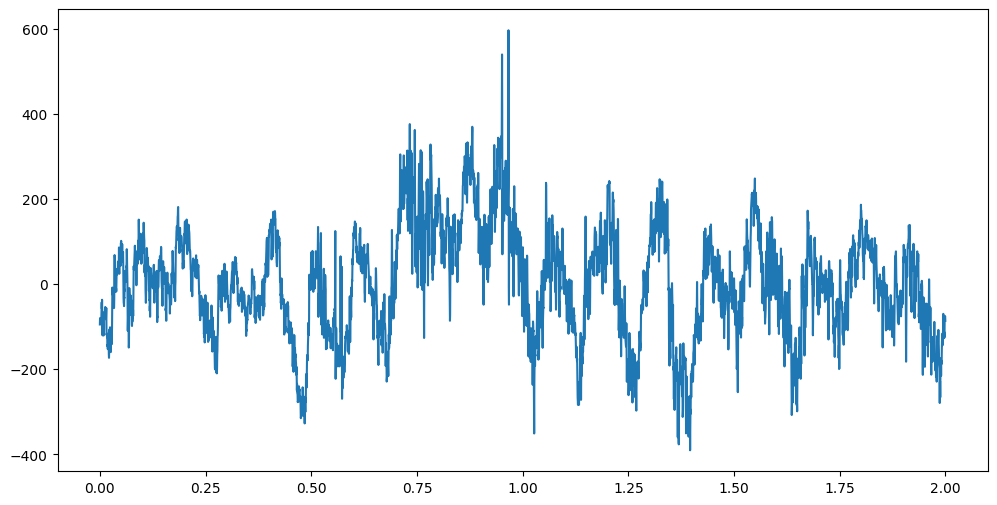

In [8]:
fs = 2500
dt = 1/fs
n_samples = len(lfp)
time = np.arange(0,n_samples*dt,dt)
plt.figure(figsize = [12,6])
plt.plot(time[0:5000],lfp[0:5000])

In [9]:
state_url = 'https://www.dropbox.com/scl/fo/vk9sq7tky0mr2z0saf96h/h/3/Rat_OS_Ephys_cbd_chronic_Rat3_407698_SD1_OR_20210601/2021-06-01_11-44-08_posttrial5/2021-06-01_11-44-08_posttrial5-states_ES2.mat?rlkey=dp39s3o16i36ox4ll1dkddscw&dl=1'
state_response = requests.get(state_url)
state_response.raise_for_status()

In [10]:
posttrial5_states_ES2 = scipy.io.loadmat(BytesIO(state_response.content))
posttrial5_states_ES2

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Nov 29 12:27:38 2021',
 '__version__': '1.0',
 '__globals__': [],
 'states': array([[1, 1, 1, ..., 1, 1, 0]], dtype=uint8),
 'events': array([], shape=(0, 0), dtype=uint8),
 'transitions': array([[1.0000000, 2047.0129622, 10800.4112741],
        [1.0000000, 0.0122588, 2556.3353597],
        [3.0000000, 455.9819132, 3600.5659164],
        [1.0000000, 3607.0540595, 3612.3745981],
        [1.0000000, 3121.7298031, 3162.6361535],
        [1.0000000, 2881.9525723, 2897.8991158],
        [4.0000000, 2867.1113344, 2882.9825161],
        [1.0000000, 2592.7017685, 2629.5134646],
        [5.0000000, 2450.2680868, 2593.2544212],
        [3.0000000, 2436.7731109, 2449.6247990],
        [4.0000000, 2436.7228698, 2450.1724277],
        [1.0000000, 2207.2504019, 2232.3860531],
        [3.0000000, 2234.3876608, 2238.9495579],
        [1.0000000, 782.0077371, 815.4532757],
        [4.0000000, 967.6317323, 1091.9585008],
        [5

# Theta Signal Extraction

In [11]:
def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states from a binary sleep state vector.

    Parameters:
    states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.

    Returns:
    numpy.ndarray: An array of consecutive REM sleep state intervals in seconds, represented as (start, end) pairs.

    Notes:
    - This function processes a binary sleep state vector and identifies consecutive REM sleep intervals.
    - It calculates the start and end times of each REM state interval based on the provided sample rate.
    - The resulting intervals are returned as a numpy array of (start, end) pairs in seconds.
    """
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states

In [13]:
s_rate= 2500
states = posttrial5_states_ES2['states']
rem_states=get_rem_states(states, s_rate).astype(int)

rem_states

array([[ 2520000,  2727500],
       [ 3465000,  3552500],
       [ 6127500,  6482500],
       [ 8890000,  9017500],
       [10732500, 10862500],
       [11877500, 12075000],
       [19257500, 19507500],
       [20730000, 20817500]])

## Artifact Removal

In [14]:
def findIntervalsA(booString):
    """
    This function takes a boolean string and returns the start and end indices of consecutive True values.

    Parameters:
        booString (numpy array) : A boolean numpy array where True values indicate the presence of a condition.

    Returns:
        numpy array : A 2D numpy array where each row represents an interval of consecutive True values in the input.
        The first column is the start index and the second column is the end index of the interval.

    Note:
    The function assumes that the input is a 1D boolean numpy array. If the input does not meet this assumption, the function may not work as expected.
    """
    booString = booString.reshape((1, len(booString)))

    starts = np.where(np.diff((np.concatenate(([False], booString[0]), axis=0)).astype(int)) > 0)[0]
    ends = np.where(np.diff((np.concatenate((booString[0], [False]), axis=0)).astype(int))< 0)[0]

    intervals = np.vstack((starts, ends)).T
    return intervals

def ConsolidateIntervalsFast(intervals, strict='off', epsilon=0):
    """
    Merge together the intervals that are overlapping.

    Parameters:
        intervals (list of tuples): List of intervals (e.g., [(start1, end1), (start2, end2), ...]).
        strict (str, optional): Intervals with common bounds are consolidated ('off') or kept separate ('on').
            Default is 'off'.
        epsilon (float, optional): Intervals with close enough bounds (distance lesser than epsilon) are also
            consolidated. Default is 0.

    Returns:
        list of tuples: Consolidated intervals.
        list of int: For each original interval, the index of the consolidated
            interval to which it belongs (empty intervals yield NaN).

    Note:
        Assumes the intervals are sorted in time and that no interval is completely contained within another.
    """
    if len(intervals) == 0:
        raise ValueError("Input list of intervals cannot be empty.")

    # Get difference between two consecutive intervals
    vector = np.array(intervals).flatten()
    d = np.diff(vector)
    d = d[1::2]

    # Define problematic spots
    if strict == 'on':
        problematic = d < epsilon
    else:
        problematic = d <= epsilon
    # Leave function if intervals don't need consolidating
    if not np.any(problematic):
        consolidated = intervals
        return consolidated

    # Mark already consolidated intervals
    problematic_etendu = np.concatenate(([False], problematic, [False]))
    done = [intervals[i] for i in range(len(intervals)) if not problematic_etendu[i] and not problematic_etendu[i+1]]


    # Initialize consolidated intervals and target list
    indices = toIntervals(problematic)
    for i in range(len(indices)):
      indices[i] = (indices[i][0], indices[i][1] + 1)
    fixed= [ (x, y) for x, y in zip([intervals[int(i) - 1][0] for i, _ in indices], [intervals[int(i) - 1][1] for _, i in indices]) ]
    #fixed = [tuple([intervals[int(i) - 1][0] for i, _ in indices], [intervals[int(i) - 1][1] for _, i in indices])]
    # Concatenate done and fixed vertically
    if done != [] and fixed != []:
      consolidated = np.vstack((done, fixed))
    elif done == []:
       consolidated = [list(el) for el in fixed]
    else:
       consolidated = [list(el) for el in done]
    # Sort the rows of consolidated based on the first column
    consolidated = np.array(consolidated)

    # Sort the rows of consolidated based on the first column
    consolidated = consolidated[consolidated[:, 0].argsort()]
    consolidated = [tuple(row) for row in consolidated]
    target = [None] * len(intervals)
    # Initialize variables for the current interval
    current_start, current_end = intervals[0]
    current_target = 1

    # Convert target indices to 1-based indexing
    target = [t + 1 if t is not None else None for t in target]
    # Return the consolidated intervals
    return consolidated

def toIntervals(x, in_ = None):
    """
    Convert logical vector to a list of intervals.

    Parameters:
        x (list) : values, e.g. timestamps
        in_ (boolean list, optional) : boolean list of the same length as x;
    Returns:
        list : A list of tuples where each tuple represents an interval. Each tuple contains two elements: the start and end of the interval.

    Note:
    _in  can also be omitted, in which case x needs to be a boolean list
    and the intervals are defined in terms of indices in the logical vector.
    """
    if len(x) == 0:
        raise ValueError('Incorrect number of parameters .')

    if in_ is None:
        in_ = np.array(in_)
        in_ = x
        x = np.linspace(1, len(x) + 1, len(x) + 1)
    else:
        in_ = np.array(in_)
        if not np.all(np.isfinite(x)):
            raise ValueError('Incorrect x values.')

    if in_[-1] == 1:
        in_ = np.append(in_, 0)

    din = np.diff(np.concatenate(([0], in_)))
    start = np.where(din == 1)[0]
    stop = np.where(din == -1)[0]

    ivs = np.column_stack((start, stop - 1))
    if len(x) > 0:
        ivs = x[ivs]

    return ivs

def InIntervals(values, intervals):
    """
    Test which values fall in a list of sorted intervals.

    Parameters:
        values (list): Sorted list of values to test.
        intervals (list of tuples): Sorted list of (start, stop) pairs representing the intervals.

    Returns:
        list: Boolean values indicating whether each value is in an interval.
    """
    result = []
    interval_index = 0

    for value in values:
        while interval_index < len(intervals) and intervals[interval_index][1] < value:
            interval_index += 1

        if interval_index < len(intervals) and intervals[interval_index][0] <= value <= intervals[interval_index][1]:
            result.append(True)
        else:
            result.append(False)

    return result

def removeArtefacts(lfp_sig, originalFreq, amp_thresh, time_win_thresh):
    """
    Removes artefacts from the LFP signal.

    Parameters:
        lfp_sig (numpy.ndarray): The LFP signal.
        originalFreq (float): The sampling frequency.
        amp_thresh (tuple): The amplitude thresholds for detecting artefacts.
                            The first one corresponds to the threshold for the absolute value of the z-scored signal.
                            The second one corresponds to the threshold to the absolute difference between a value and its predecessor of the z-scored signal.
        time_win_thresh (tuple): The time windows that will be set to zero before and after the detected artefacts.
                                 The first one corresponds to the window for the absolute value of the z-scored signal.
                                 The second one corresponds to the window for the absolute difference between a value and its predecessor of the z-scored signal.
    Returns:
        numpy.ndarray: The corrected LFP signal.
        numpy.ndarray: The indices of the artefacts.
        numpy.ndarray: The corresponding time.

    Note :
        This function only set to zero the detected artefacts.
    """
    time = np.linspace(0, len(lfp_sig)/originalFreq, len(lfp_sig))
    lfp_sig = np.array(lfp_sig)
    # Parameters
    threshold1 = amp_thresh[0]  # in sigmas deviating from the mean
    aroundArtefact1 = time_win_thresh[0]  # 2, Big and long artefacts
    threshold2 = amp_thresh[1]  # for derivative of z-scored signal
    aroundArtefact2 = time_win_thresh[1]  # 0.1 Very fast fluctuations (short time scale)

    # Performing the computations
    timeValues = time
    sig_values = lfp_sig.copy()
    z_sig = (sig_values - np.mean(sig_values)) / np.std(sig_values)
    z_sig = np.ravel(z_sig)
    diff_sig = np.concatenate((np.diff(z_sig),[0]), axis=0)
    artefactInds = np.zeros(len(sig_values), dtype=bool)
    findIntervalsA(np.abs(z_sig)>threshold1)
    # First we detect the large global artefacts
    artefactInterval = timeValues[findIntervalsA(np.abs(z_sig)>threshold1)]
    #if np.size(artefactInterval) == 2:
      #artefactInterval = np.ravel(artefactInterval)
    if artefactInterval.size != 0:
      array_artefactInterval= [ (x, y) for x, y in zip(artefactInterval[:,0]-aroundArtefact1, artefactInterval[:,1]+aroundArtefact1) ]
      artefactInterval = ConsolidateIntervalsFast(array_artefactInterval);
      artefactInds = InIntervals(timeValues, artefactInterval)
    else:
      artefactInterval = np.zeros((0, 2))

    # Find noise using the derivative of the zscored signal (2)
    noisyInterval = timeValues[findIntervalsA(np.abs(diff_sig)>threshold2)]
    #if np.size(noisyInterval) == 2:
      #noisyInterval = np.ravel(noisyInterval)
    if noisyInterval.size != 0:
      array_noisyInterval= [ (x, y) for x, y in zip(noisyInterval[:,0]-aroundArtefact2, noisyInterval[:,1]+aroundArtefact2) ]
      noisyInterval = ConsolidateIntervalsFast(array_noisyInterval);
      artefactInds = np.logical_or(artefactInds, InIntervals(timeValues, noisyInterval))
    else:
      noisyInterval = np.zeros((0, 2))

    artefactInds = np.array(artefactInds)
    sig_values = np.ravel(sig_values)
    sig_values[artefactInds] = 0

    return sig_values, artefactInds, timeValues

def artefact_epochs(artefactsIndices, window_length, threshold = 0):
    """
    Get the indices of the epochs containing artefacts

    Parameters:
        artefactsIndices (list): the indices of the artefacts in the raw data.
        window_length (int) : the length of an epoch
        threshold (float, optional) : percentage of artefact necessary for an epoch to be detected as an artefact.

    Returns:
        numpy.ndarray : the indices of the epochs containing a percetage of artefacts greater than the threshold.
    """
    artefactsCountEpochs = artefactsIndices[:len(artefactsIndices)//window_length * window_length].reshape(-1, window_length)
    artefactsCountEpochs = [np.count_nonzero(el) for el in artefactsCountEpochs]
    art_percentage_per_epoch = np.ravel([(el/(window_length))*100  for el in artefactsCountEpochs])

    arte_indices = []
    for i, el in enumerate(art_percentage_per_epoch):
        if el > threshold:
            arte_indices.append(i)
    arte_indices = np.ravel(arte_indices)
    return arte_indices

In [16]:
hpc_clean, hpcNoisyIdx, timeValues = removeArtefacts(lfp, s_rate, [4, 8], [1, 0.1])

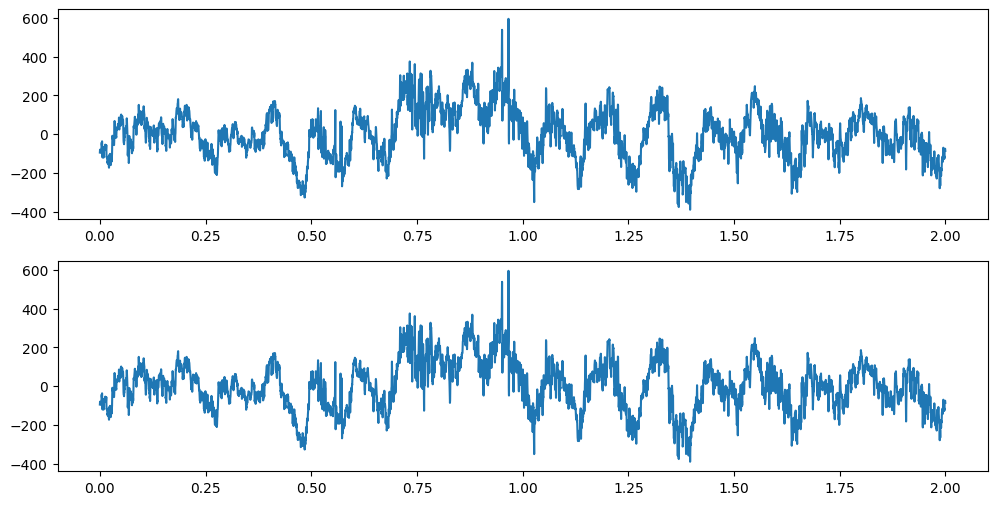

In [17]:
lfp_clean = hpc_clean

plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time[0:5000],lfp[0:5000])
plt.subplot(2,1,2)
plt.plot(time[0:5000],lfp_clean[0:5000])

</p> We know that the removeArtefacts function sets to zero the indices that are labled as artifact so in the next block I'm trying to check if they work and how many samples have been altered.

In [18]:
num_zeros_lfp = len(lfp) - np.count_nonzero(lfp)
num_zeros_lfp_clean = len(lfp_clean) - np.count_nonzero(lfp_clean)
difference_in_zeros = abs(num_zeros_lfp - num_zeros_lfp_clean)

print(f"Number of zeroes in lfp: {num_zeros_lfp}")
print(f"Number of zeroes in lfp_clean: {num_zeros_lfp_clean}")
print(f"Difference in the number of zeroes: {difference_in_zeros}")

Number of zeroes in lfp: 0
Number of zeroes in lfp_clean: 530352
Difference in the number of zeroes: 530352


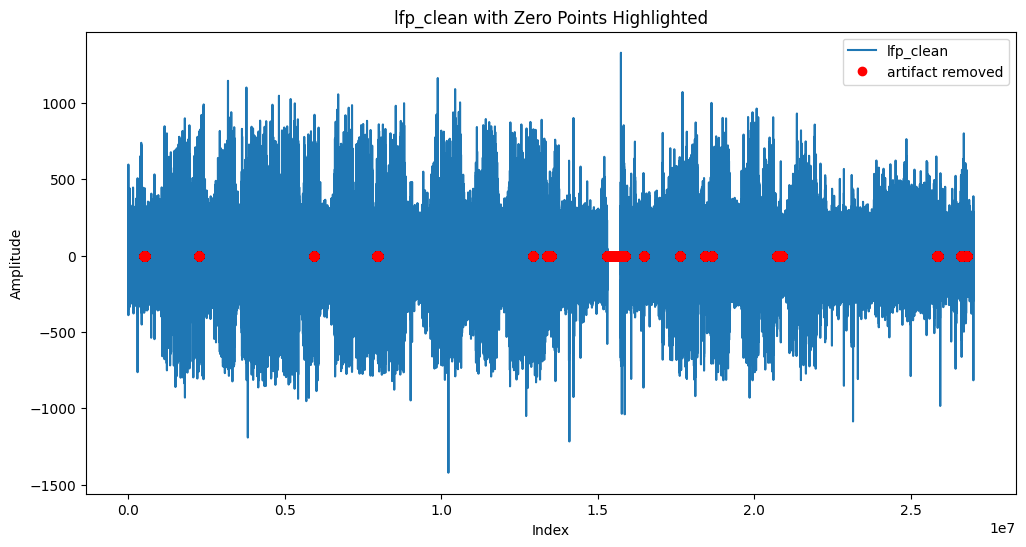

In [19]:
zero_indices = np.where(lfp_clean == 0)[0]

plt.figure(figsize=[12, 6])
plt.plot(lfp_clean, label='lfp_clean')

plt.plot(zero_indices, lfp_clean[zero_indices], 'ro', label='artifact removed')

plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('lfp_clean with Zero Points Highlighted')
plt.legend()

In [20]:
rem_sections = []
for ii in np.arange(rem_states.shape[0]):
  rem_sections.append(lfp_clean[rem_states[ii,0]:rem_states[ii,1]])

## Regular Sifting

<Axes: xlabel='Time (samples)'>

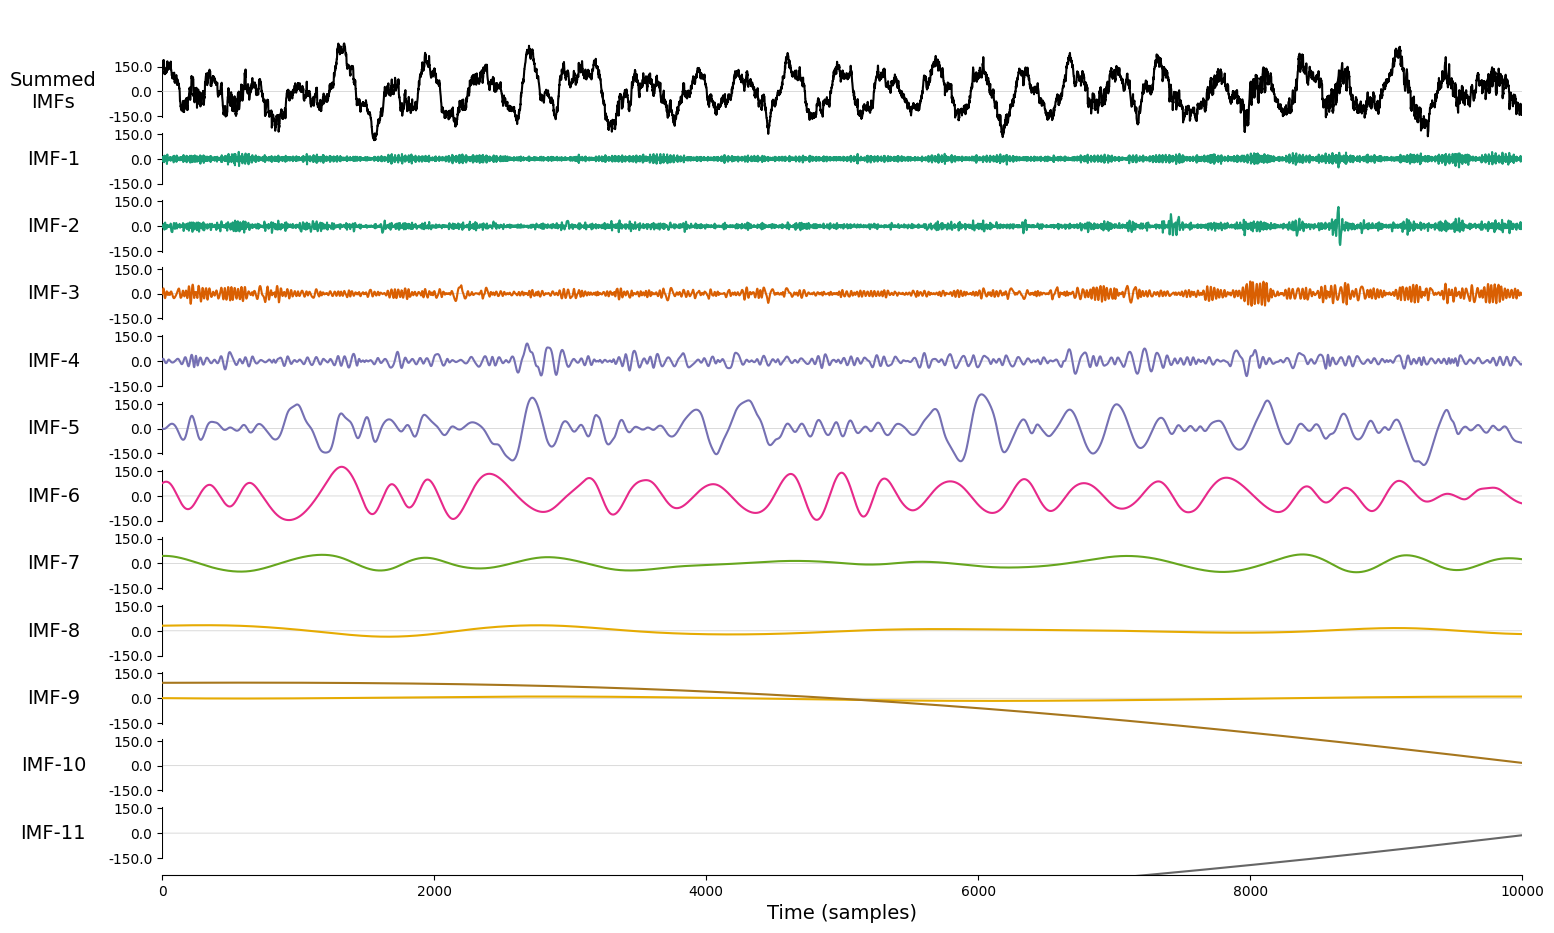

In [21]:
# Get the default configuration for a sift
config = emd.sift.get_config('sift')
# Adjust the threshold for accepting an IMF
config['imf_opts/sd_thresh'] = 0.05
config['extrema_opts/method'] = 'rilling'

imf_regular = emd.sift.sift(rem_sections[-1])

emd.plotting.plot_imfs(imf_regular[:10000,:])

<p/> IMF4, 5 and 6 clearly have frequency overlap.

## Ensemble Sifting

<Axes: xlabel='Time (samples)'>

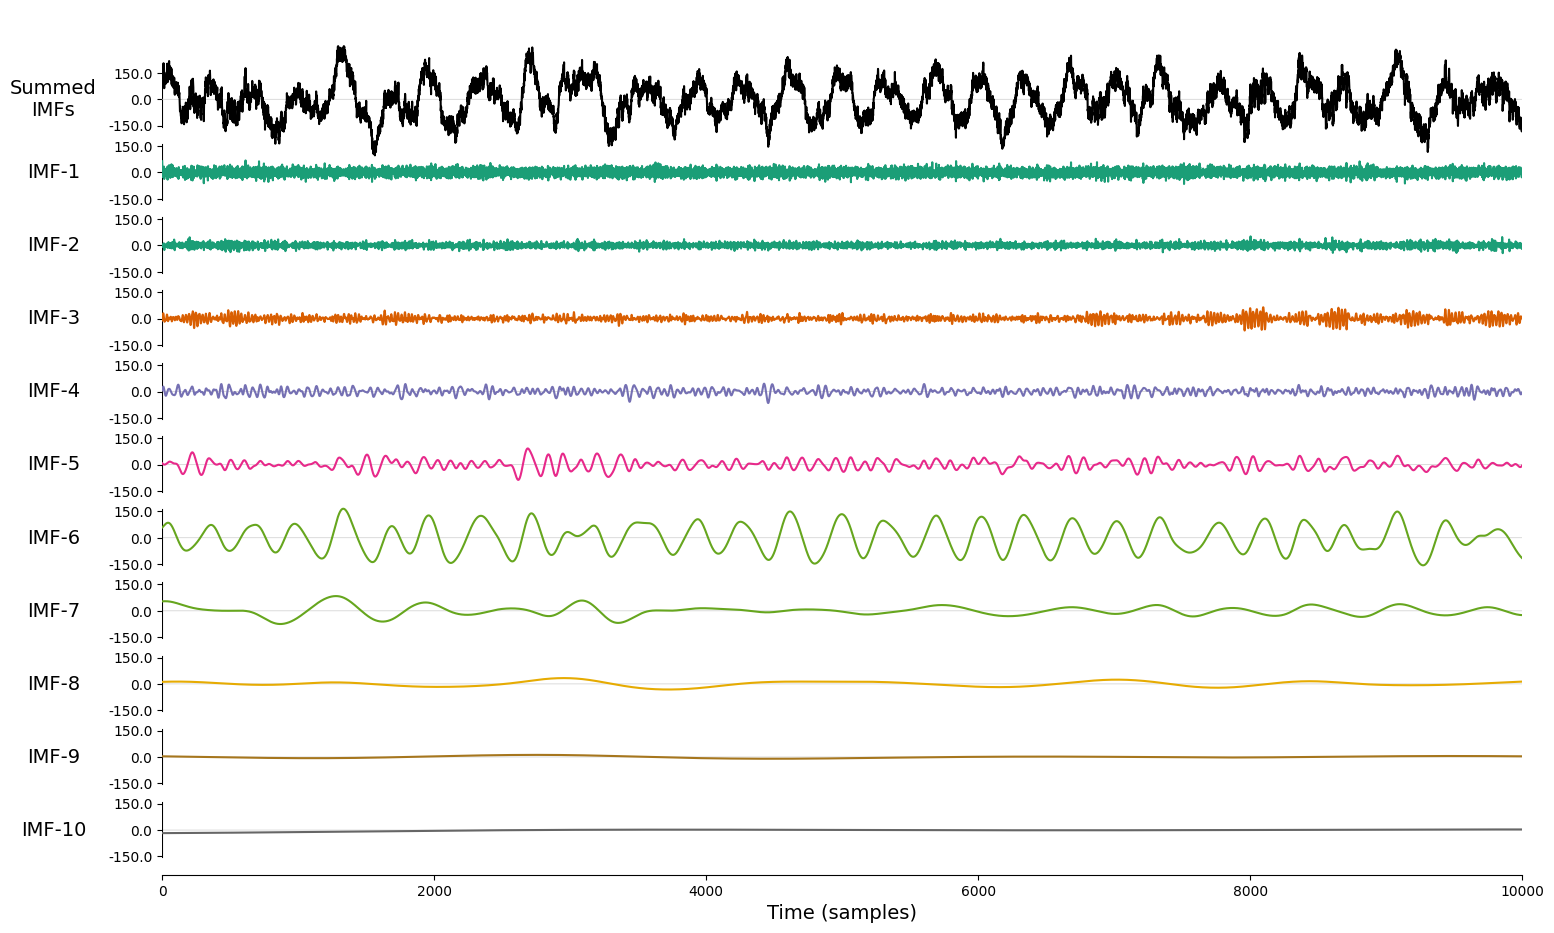

In [22]:
imf_ensemble = emd.sift.ensemble_sift(rem_sections[-1], max_imfs=11, nensembles=30, nprocesses=6, ensemble_noise=1, imf_opts = {'sd_thresh': 0.05})
emd.plotting.plot_imfs(imf_ensemble[:10000,:])

<p> Still there seems to be an overlap in IMF2 and IMF3 but it has improved compared to regular sifting.

In [25]:
rem_sections[-1].shape

(87500,)

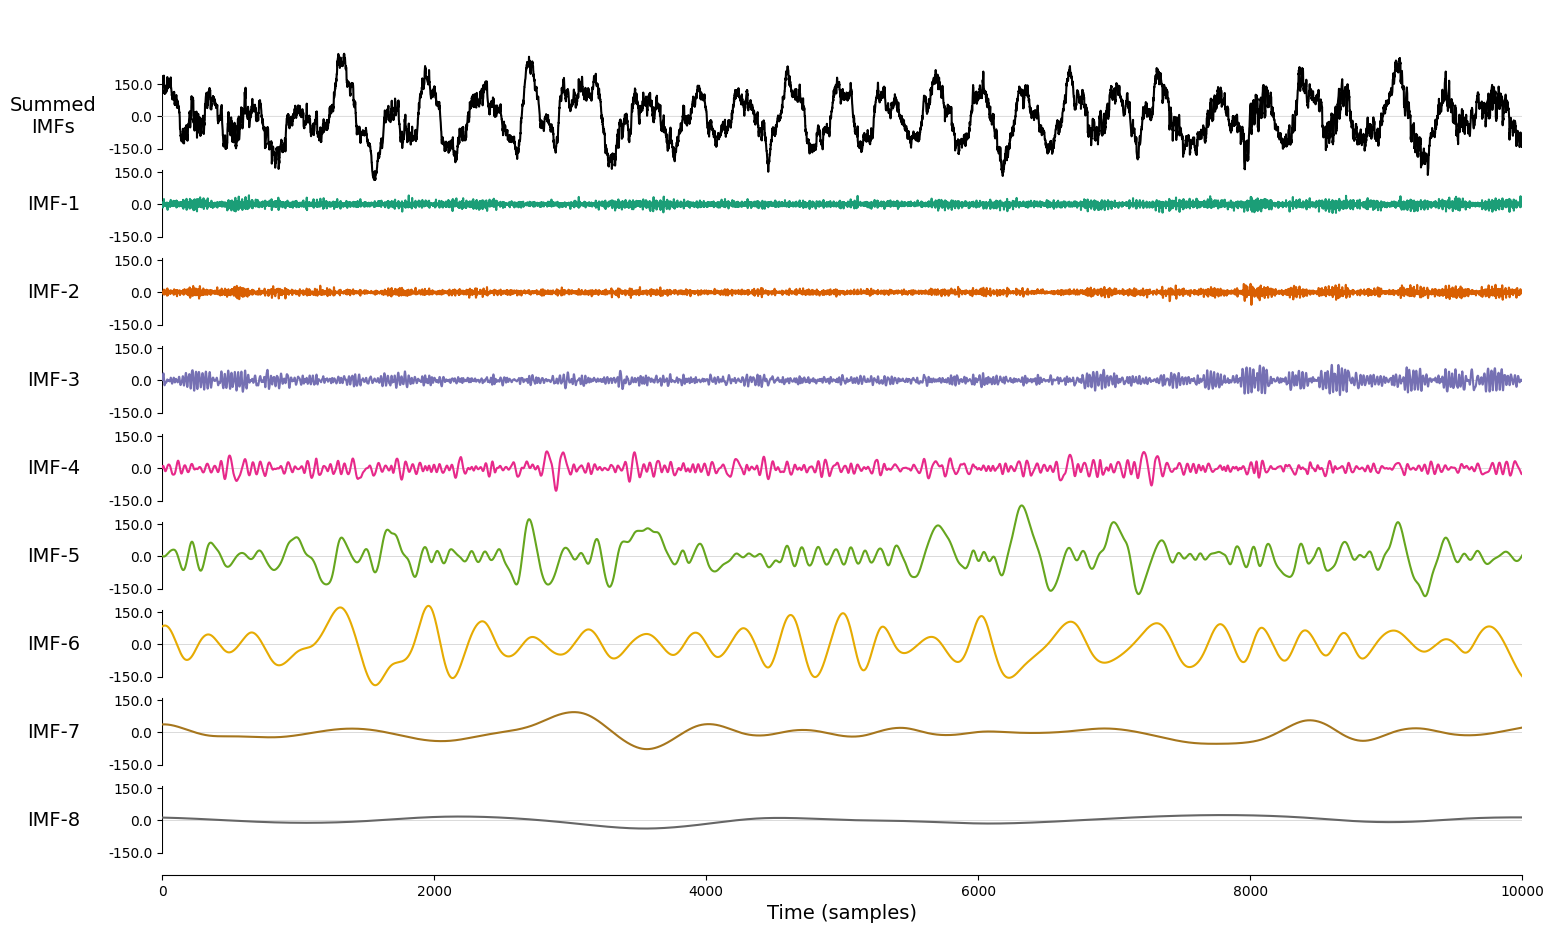

In [27]:
imf_censemble = emd.sift.complete_ensemble_sift(rem_sections[-1],  max_imfs=6)
censemblefig=emd.plotting.plot_imfs(imf_censemble[:10000,:]).get_figure()

## Masked Sifting

<Axes: xlabel='Time (samples)'>

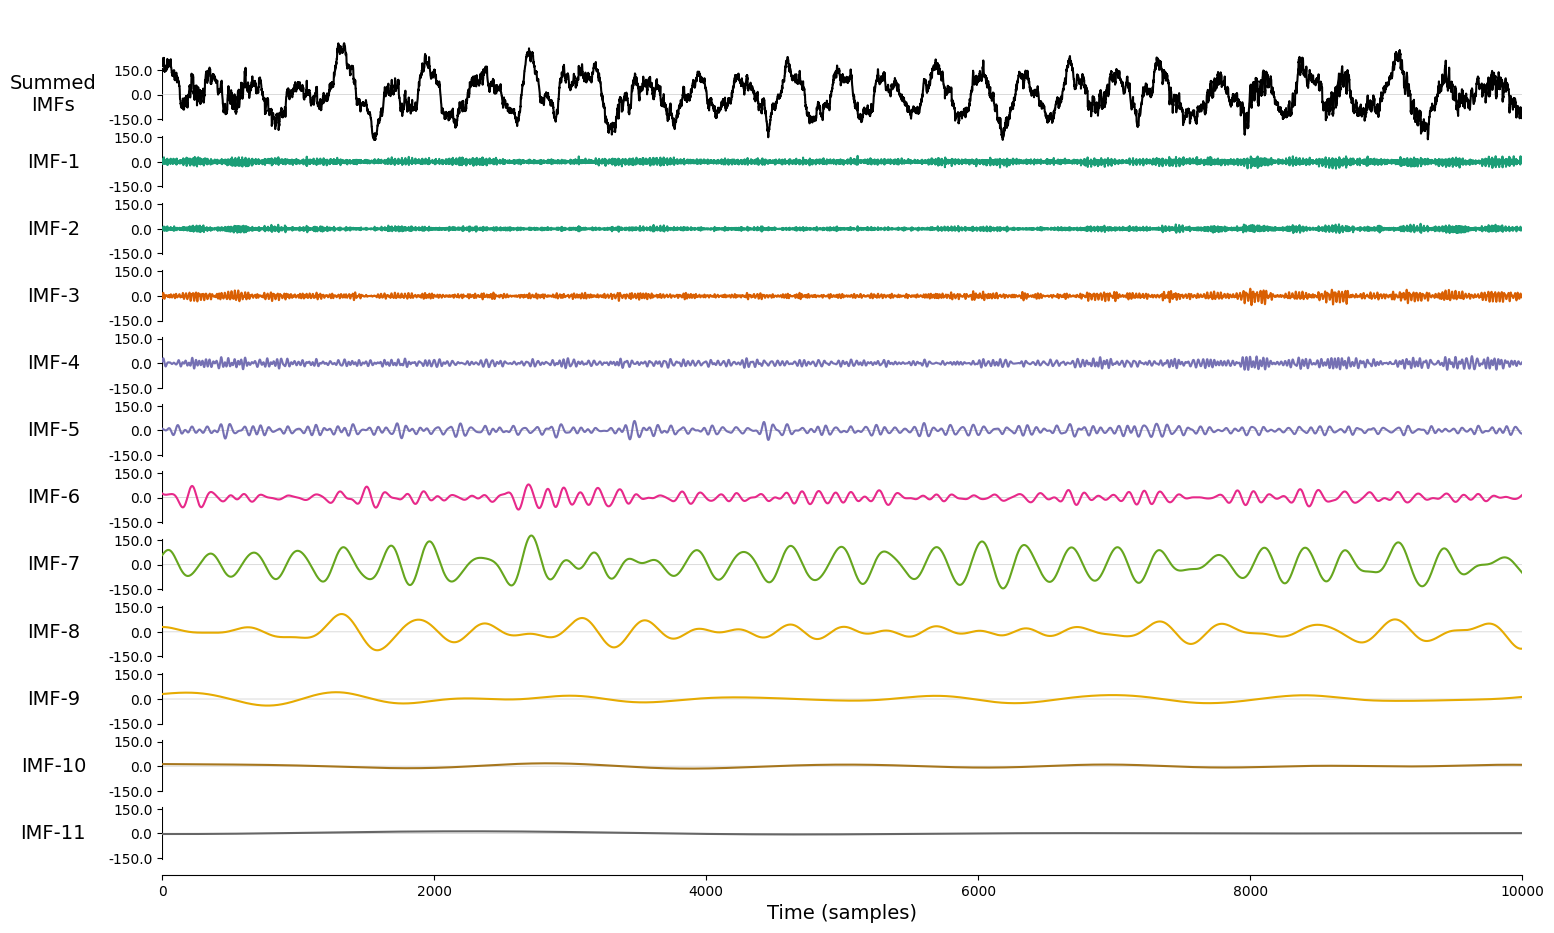

In [28]:
imf_masked_zc, mask_freqs_zc = emd.sift.mask_sift(rem_sections[-1], mask_freqs='zc', ret_mask_freq=True, max_imfs=11)
emd.plotting.plot_imfs(imf_masked_zc[:10000,:])

<Axes: xlabel='Time (samples)'>

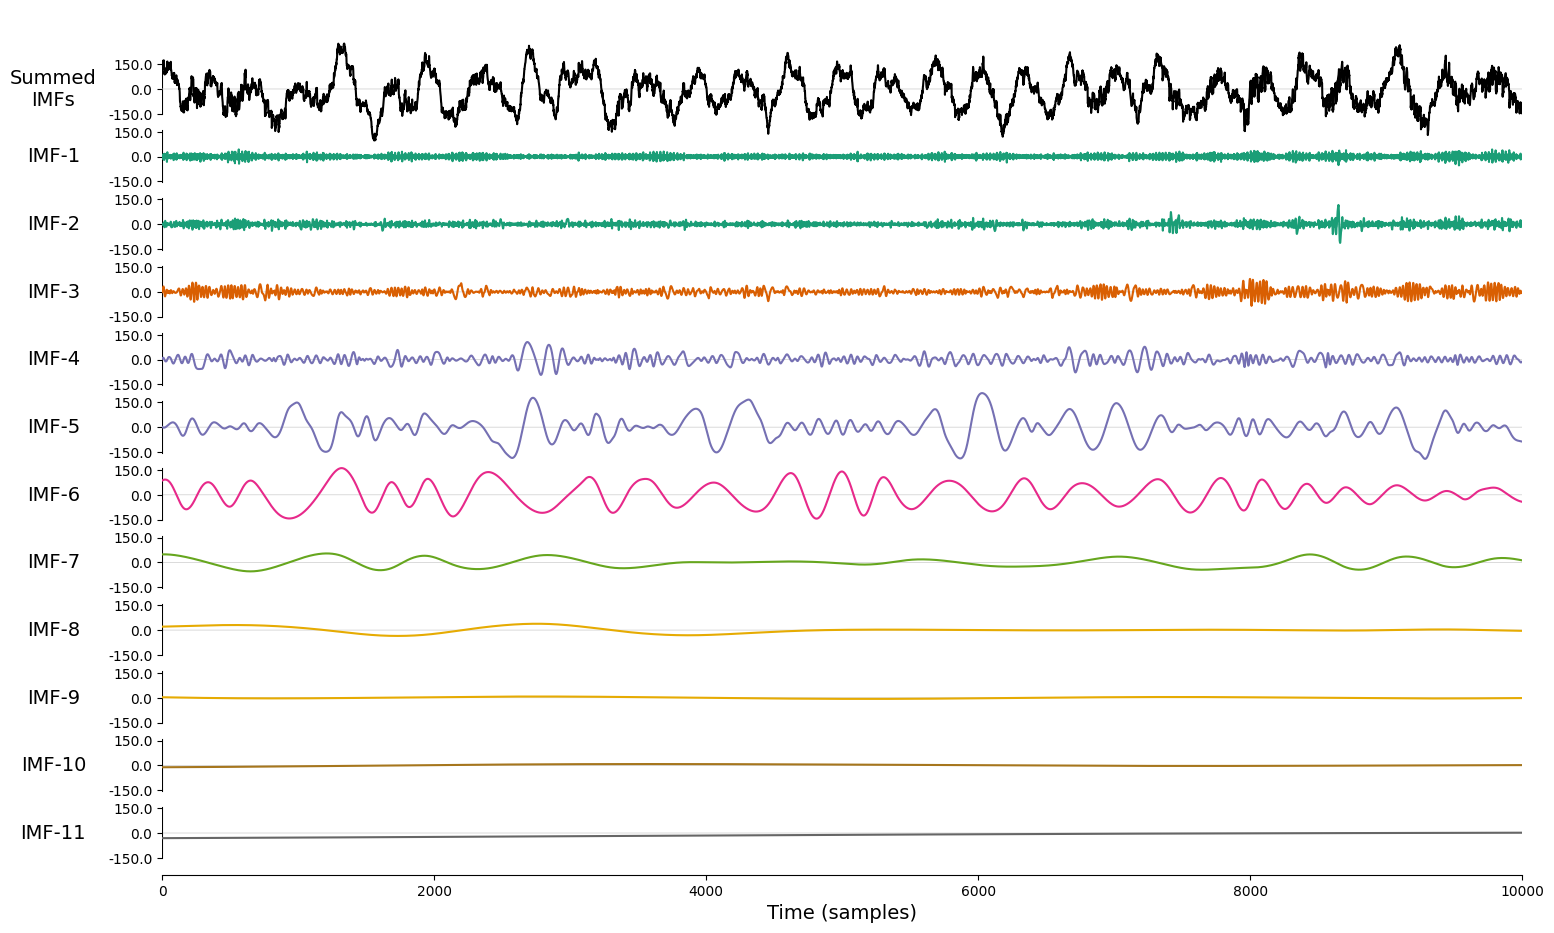

In [29]:
imf_masked_if, mask_freqs_if = emd.sift.mask_sift(rem_sections[-1], mask_freqs='if', ret_mask_freq=True, max_imfs=11)
emd.plotting.plot_imfs(imf_masked_if[:10000,:])

<Axes: xlabel='Time (samples)'>

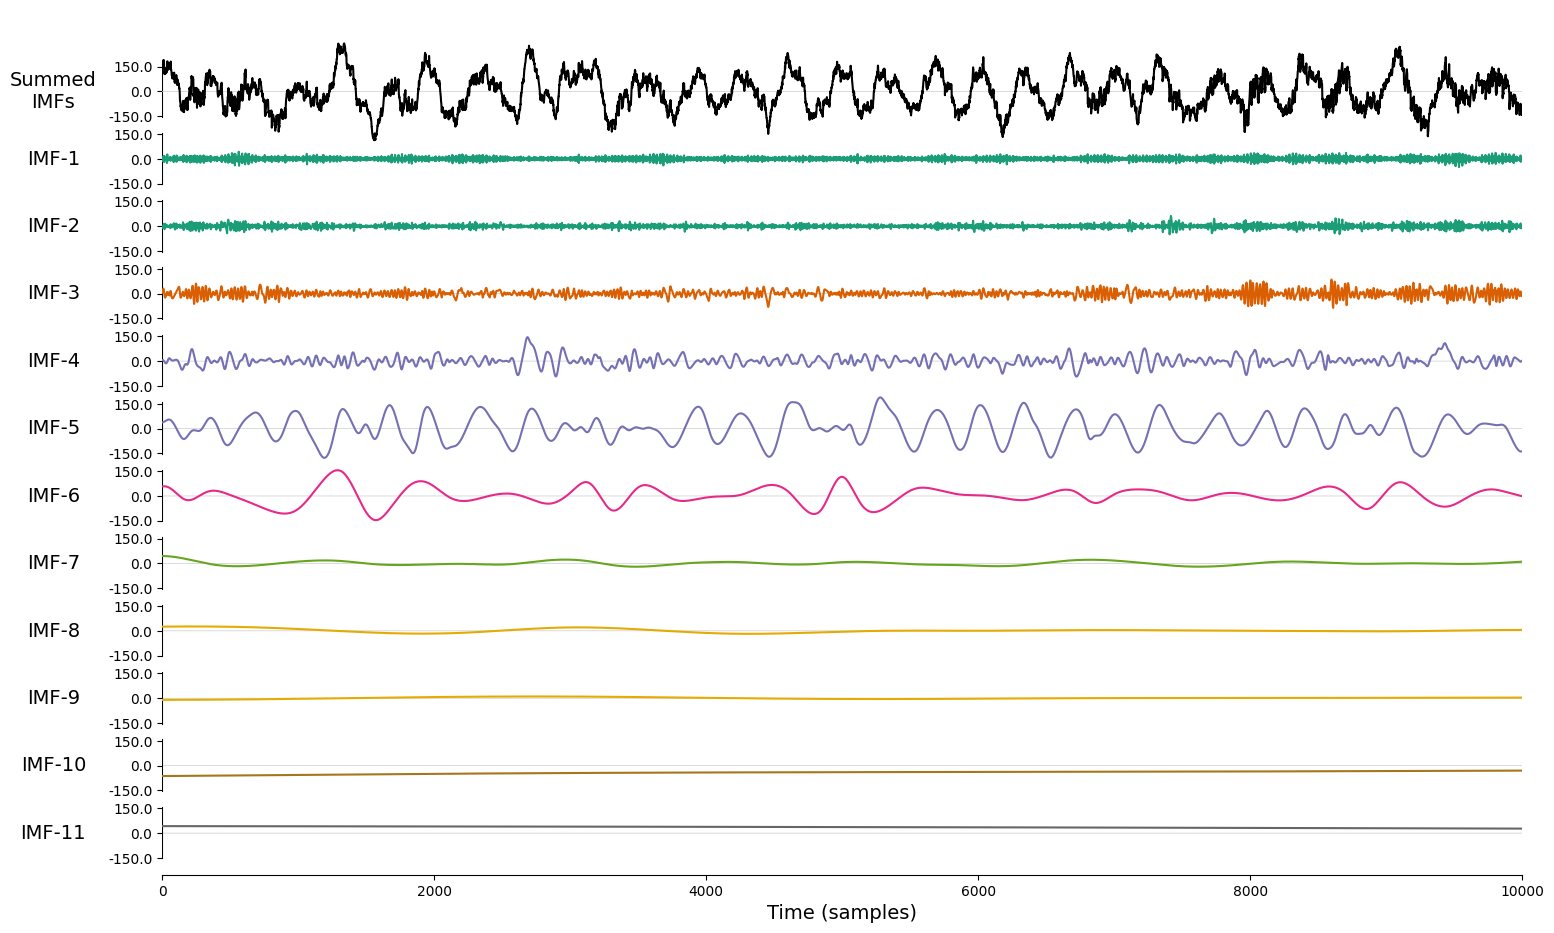

In [30]:
imf_masked_manual, mask_freqs_manual = emd.sift.mask_sift(rem_sections[-1], mask_freqs=15/s_rate, ret_mask_freq=True, max_imfs=11)
emd.plotting.plot_imfs(imf_masked_manual[:10000,:])

<p> both in zero crossing and manual mask frequency, this sift didn't do well.

## Iterative masked sifting

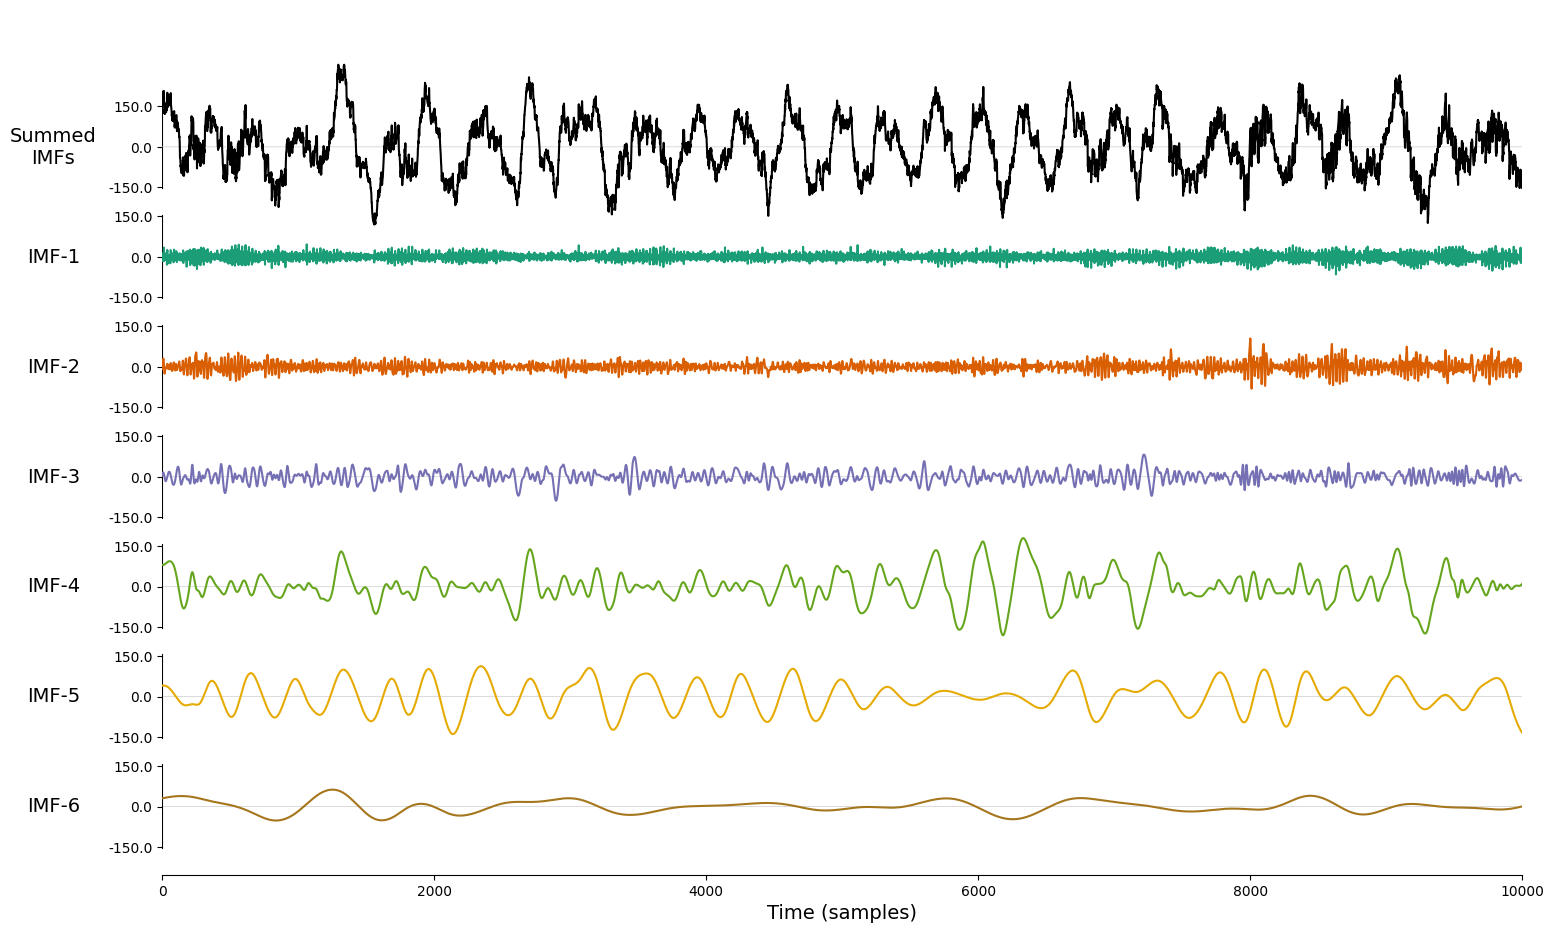

In [31]:
imf_imask , imask_freq = emd.sift.iterated_mask_sift(rem_sections[-1],mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')
imaskzcfig=emd.plotting.plot_imfs(imf_imask[:10000,:]).get_figure()

## Bandpass Filter

In [32]:
time=len(rem_sections[-1])/s_rate
seconds=np.linspace(0,time,len(rem_sections[-1]))

Wlo = [5,12]
Whi=[60,80]# Set the passband [2-10] Hz,
n = 50;                            # ... and filter order,
                                    # ... build the bandpass filter,
a = signal.firwin(n, Wlo, fs=s_rate, pass_zero=False, window='hamming');
Vlo = signal.filtfilt(a, 1, rem_sections[-1]);
VloX=scipy.fft.fft(Vlo)
VloXA=2*abs(VloX)/len(rem_sections[-1])

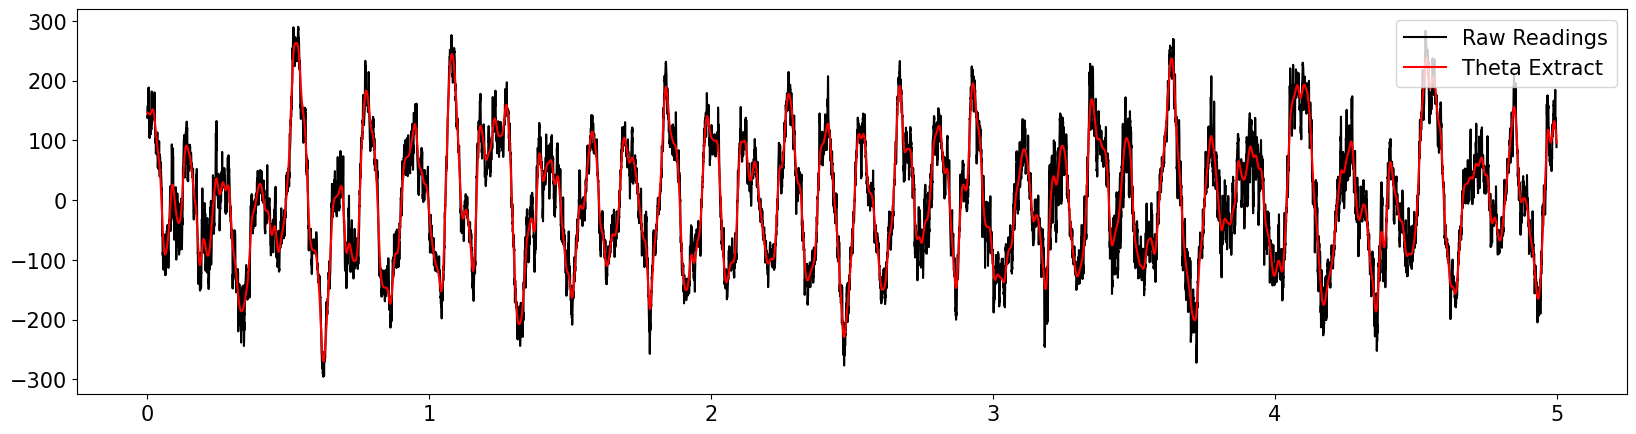

In [33]:
plt.gcf().set_size_inches(20, 5)
plt.rcParams.update({'font.size': 15})
# plt.plot(seconds[:sample_rate],Vhi[:sample_rate])
plt.plot(seconds[:5*s_rate],rem_sections[-1][:5*s_rate],'-k',label='Raw Readings')
plt.plot(seconds[:5*s_rate],Vlo[:5*s_rate],'-r',label='Theta Extract')

plt.legend(loc="upper right")

## Defining the theta-gamma split function

In [34]:
# Define a simple function to calcuclate the average frequencies of each IMF

def imf_freq(imf,sample_rate,mode='nht'):
  _,IF,_=emd.spectra.frequency_transform(imf,sample_rate,'nht')
  freq_vec=np.mean(IF,axis=0)
  return freq_vec

In [35]:
# Example of the average frequencies calculated from IMFs of normal sifting

sift_mask_freq= imf_freq(imf_regular,s_rate)
print(f'{sift_mask_freq} in Hz')

[0.6259424 271.3108056 100.5408508 40.8853188 13.1983746 5.2842322
 2.1428371 0.8560692 0.2559381 0.0563382 0.0555564] in Hz


In [36]:
# Defining the theta gamma split function

def tg_split(mask_freq, theta_range=(5, 12)):
    """
        Split a frequency vector into sub-theta, theta, and supra-theta components.

        Parameters:
        mask_freq (numpy.ndarray): A frequency vector or array of frequency values.
        theta_range (tuple, optional): A tuple defining the theta frequency range (lower, upper).
            Default is (5, 12).

        Returns:
        tuple: A tuple containing boolean masks for sub-theta, theta, and supra-theta frequency components.

        Notes: - This function splits a frequency mask into three components based on a specified theta frequency
        range. - The theta frequency range is defined by the 'theta_range' parameter. - The resulting masks 'sub',
        'theta', and 'supra' represent sub-theta, theta, and supra-theta frequency components.
    """
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index

    return sub, theta, supra

Text(0.5, 1.0, 'Complete Ensemble sift')

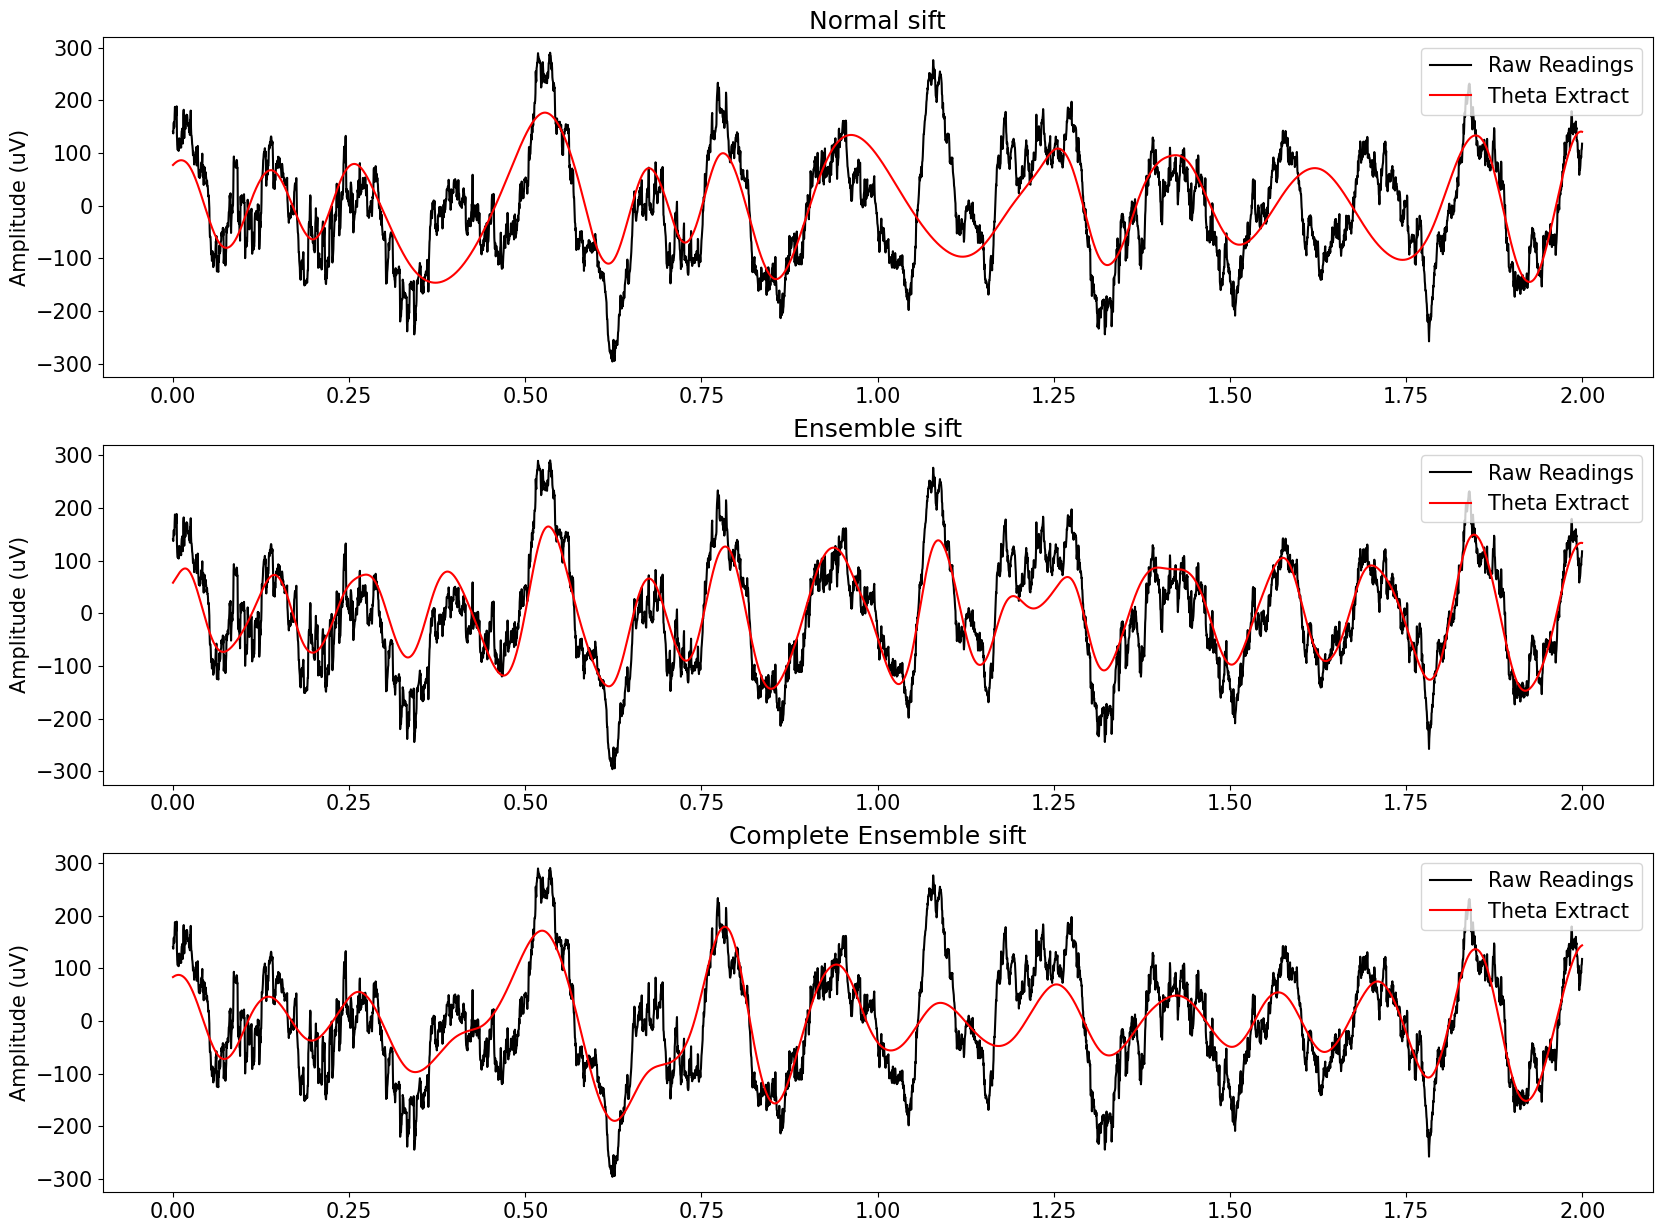

In [38]:
#Creating the subplot
fig1,ax1=plt.subplots(3,figsize=(20,15))
plt.rcParams.update({'font.size': 15})

two_sec_sig = rem_sections[-1][:2*s_rate]

#Normal sift
_,sift_theta,_=tg_split(sift_mask_freq)
sift_thetasig= np.sum(imf_regular.T[sift_theta],axis=0)
ax1[0].plot(seconds[:5000],two_sec_sig,'-k',label='Raw Readings')
ax1[0].plot(seconds[:5000],sift_thetasig[:5000],'-r',label='Theta Extract')
ax1[0].legend(loc="upper right")
ax1[0].set_ylabel(r'Amplitude (uV)')
ax1[0].set_title('Normal sift')

##### Ensemble Sift
ensemble_mask_freq= imf_freq(imf_ensemble,s_rate)
_,ensemble_theta,_=tg_split(ensemble_mask_freq)
ensemble_thetasig= np.sum(imf_ensemble.T[ensemble_theta],axis=0)
ax1[1].plot(seconds[:5000],two_sec_sig,'-k',label='Raw Readings')
ax1[1].plot(seconds[:5000],ensemble_thetasig[:5000],'-r',label='Theta Extract')
ax1[1].legend(loc="upper right")
ax1[1].set_ylabel(r'Amplitude (uV)')
ax1[1].set_title('Ensemble sift')

##### Complete Ensemble Sift
censemble_mask_freq= imf_freq(imf_censemble,s_rate)
_,censemble_theta,_=tg_split(censemble_mask_freq)
censemble_thetasig= np.sum(imf_censemble.T[censemble_theta],axis=0)
ax1[2].plot(seconds[:5000],two_sec_sig,'-k',label='Raw Readings')
ax1[2].plot(seconds[:5000],censemble_thetasig[:5000],'-r',label='Theta Extract')
ax1[2].legend(loc="upper right")
ax1[2].set_ylabel(r'Amplitude (uV)')
ax1[2].set_title('Complete Ensemble sift')

Text(0.5, 1.0, 'Iterated Mask Sift')

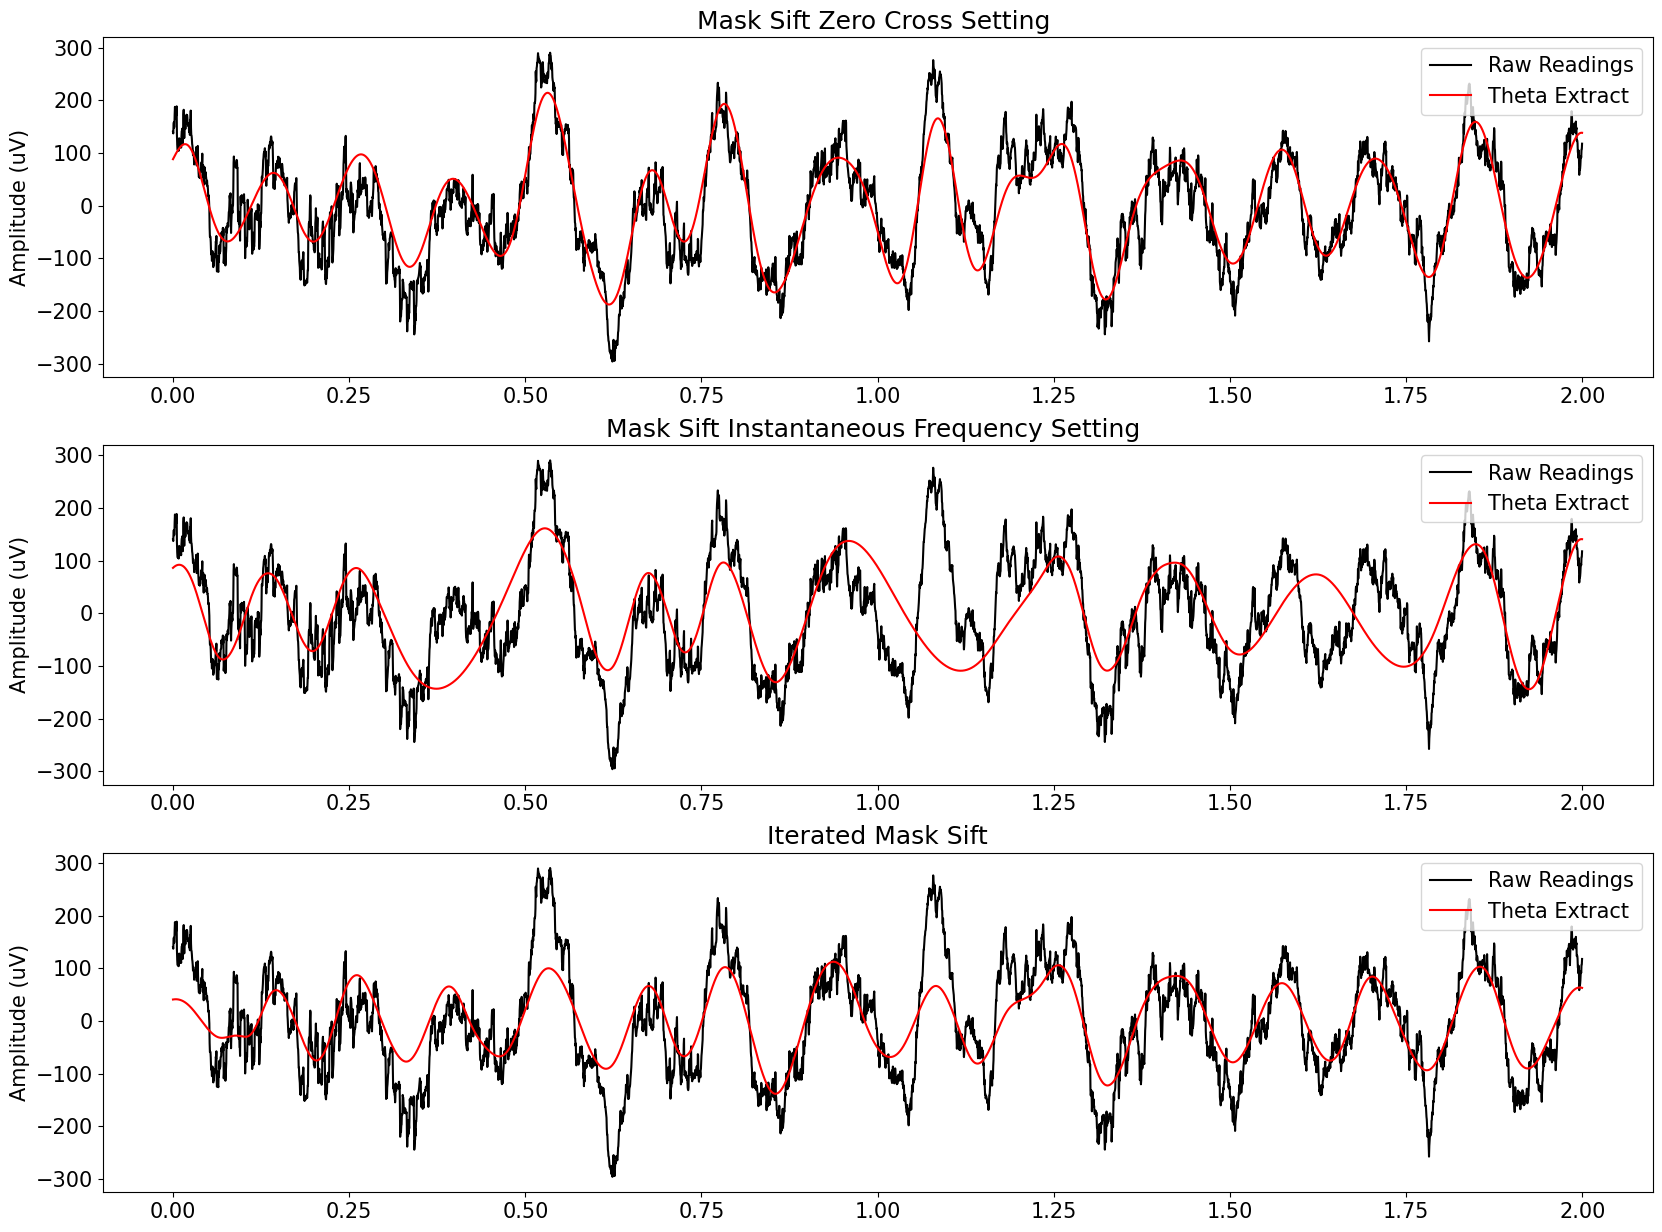

In [39]:
fig2,ax2=plt.subplots(3,figsize=(20,15))
plt.rcParams.update({'font.size': 15})

# Mask Sift Zero Cross Setting

mask_freqs_zc = imf_freq(imf_masked_zc,s_rate)
_ ,maskzc_theta, _=tg_split(mask_freqs_zc)
maskzc_thetasig= np.sum(imf_masked_zc.T[maskzc_theta],axis=0)
ax2[0].plot(seconds[:5000],two_sec_sig,'-k',label='Raw Readings')
ax2[0].plot(seconds[:5000],maskzc_thetasig[:5000],'-r',label='Theta Extract')
ax2[0].legend(loc="upper right")
ax2[0].set_ylabel(r'Amplitude (uV)')
ax2[0].set_title('Mask Sift Zero Cross Setting ')

# Mask Sift Instantaneous Frequency Setting
mask_freqs_if = imf_freq(imf_masked_if,s_rate)
_,maskif_theta,_=tg_split(mask_freqs_if)
maskif_thetasig= np.sum(imf_masked_if.T[maskif_theta],axis=0)
ax2[1].plot(seconds[:5000],two_sec_sig,'-k',label='Raw Readings')
ax2[1].plot(seconds[:5000],maskif_thetasig[:5000],'-r',label='Theta Extract')
ax2[1].legend(loc="upper right")
ax2[1].set_ylabel(r'Amplitude (uV)')
ax2[1].set_title('Mask Sift Instantaneous Frequency Setting ')

# Iterated Mask Sift
imask_freq = imf_freq(imf_imask,s_rate)
_,imask_theta,_=tg_split(imask_freq)
imask_thetasig= np.sum(imf_imask.T[imask_theta],axis=0)
ax2[2].plot(seconds[:5000],two_sec_sig,'-k',label='Raw Readings')
ax2[2].plot(seconds[:5000],imask_thetasig[:5000],'-r',label='Theta Extract')
ax2[2].legend(loc="upper right")
ax2[2].set_ylabel(r'Amplitude (uV)')
ax2[2].set_title('Iterated Mask Sift')

<p> As visualized the iterative masked sifting & mask zero cross setting sifting did the best between all other sifting.

# Cycle Detection

## Zero Crossing Detection

In [40]:
# Defining Zero-Cross detection function

def zero_cross(x):
    """
    Find the indices of zero-crossings in a 1D signal.

    Parameters:
    x (numpy.ndarray): The input 1D signal.

    Returns:
    numpy.ndarray: An array of indices where zero-crossings occur in the input signal.

    Notes:
    - This function identifies the indices where zero-crossings occur in a given 1D signal.
    - It detects both rising and falling zero-crossings.
    """
    decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]
    rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]
    zero_xs = np.sort(np.append(rise, decay))
    return zero_xs

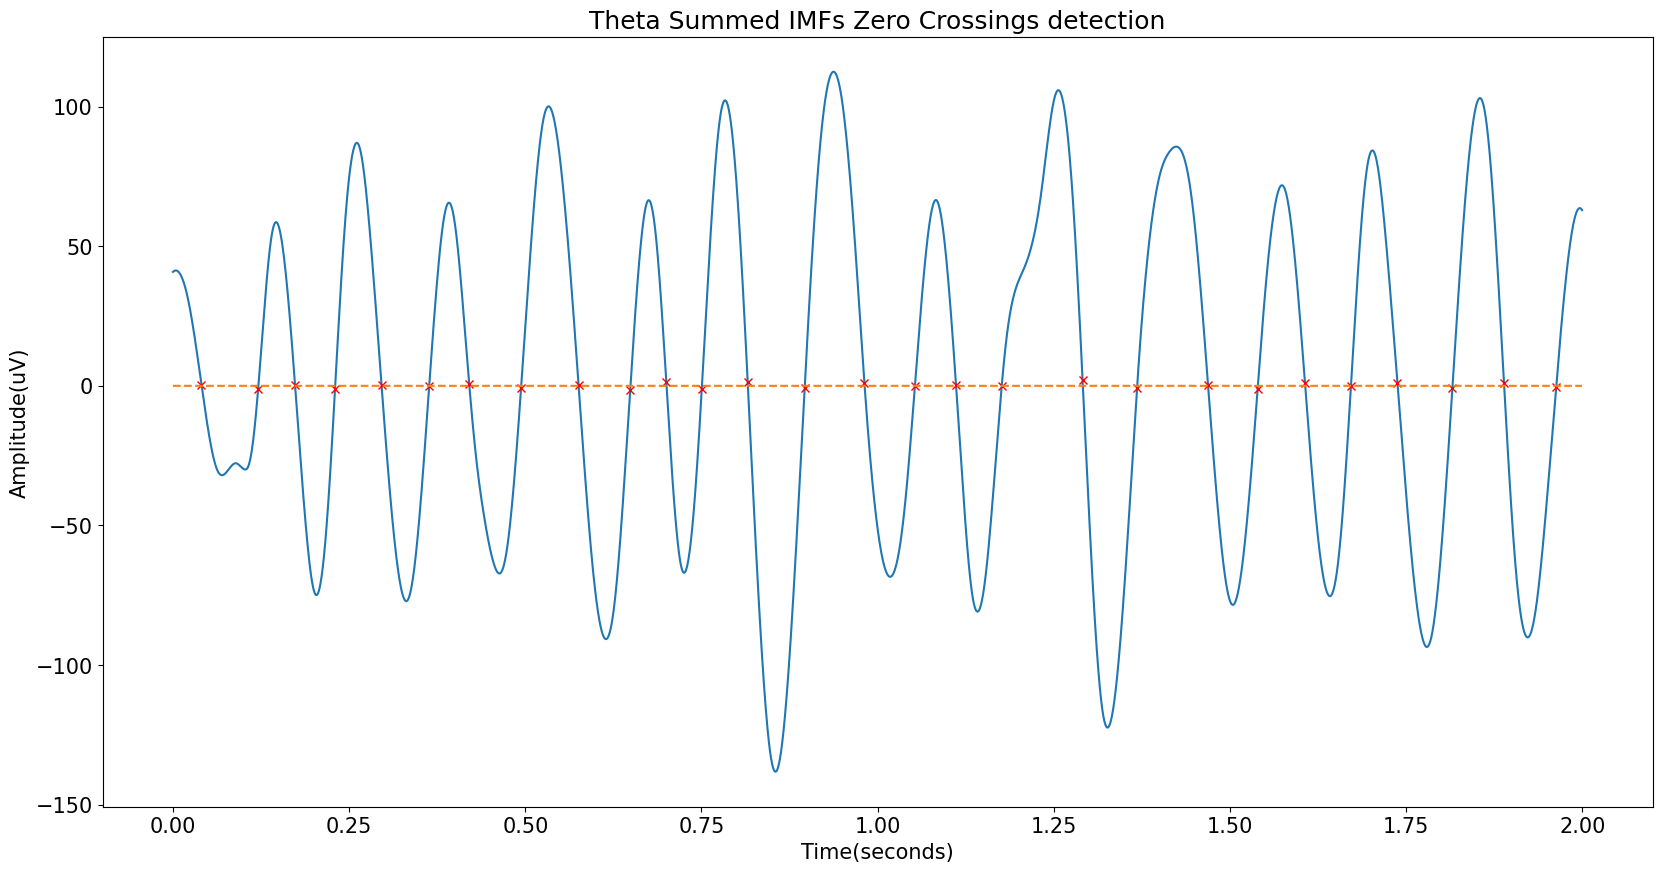

In [42]:
# Parsing Zero-Cross indices

zero_x = zero_cross(imask_thetasig)


# Plotting the zero crossing locations

plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:5000],imask_thetasig[:5000])
plt.plot(seconds[zero_x[zero_x <= 2*s_rate]],imask_thetasig[zero_x[zero_x <= 2*s_rate]], "x",color='red')
plt.plot(seconds[0:5000],np.zeros(5000),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('Theta Summed IMFs Zero Crossings detection')
plt.show()

## Trough and Peak Detection

In [43]:
# Defining the extrema function
def extrema(x):
    """
    Find extrema (peaks, troughs) and zero crossings in a 1D signal.

    Parameters:
    x (numpy.ndarray): The input 1D signal.

    Returns:
    tuple: A tuple containing:
        - numpy.ndarray: Indices of zero-crossings in the input signal.
        - numpy.ndarray: Indices of troughs in the input signal.
        - numpy.ndarray: Indices of peaks in the input signal.

    Notes:
    - This function identifies and returns the indices of zero-crossings, troughs, and peaks in a given 1D signal.
    - Zero-crossings are points where the signal crosses the zero axis.
    - Troughs are local minima, and peaks are local maxima in the signal.
    """
    zero_xs = zero_cross(x)
    peaks = np.empty((0,)).astype(int)
    troughs = np.empty((0,)).astype(int)
    for t1, t2 in zip(zero_xs, zero_xs[1:]):
        extrema0 = np.argmax(np.abs(x[t1:t2])).astype(int) + t1
        if bool(x[extrema0] > 0):
            peaks = np.append(peaks, extrema0)
        else:
            troughs = np.append(troughs, extrema0)
    return zero_xs, troughs, peaks

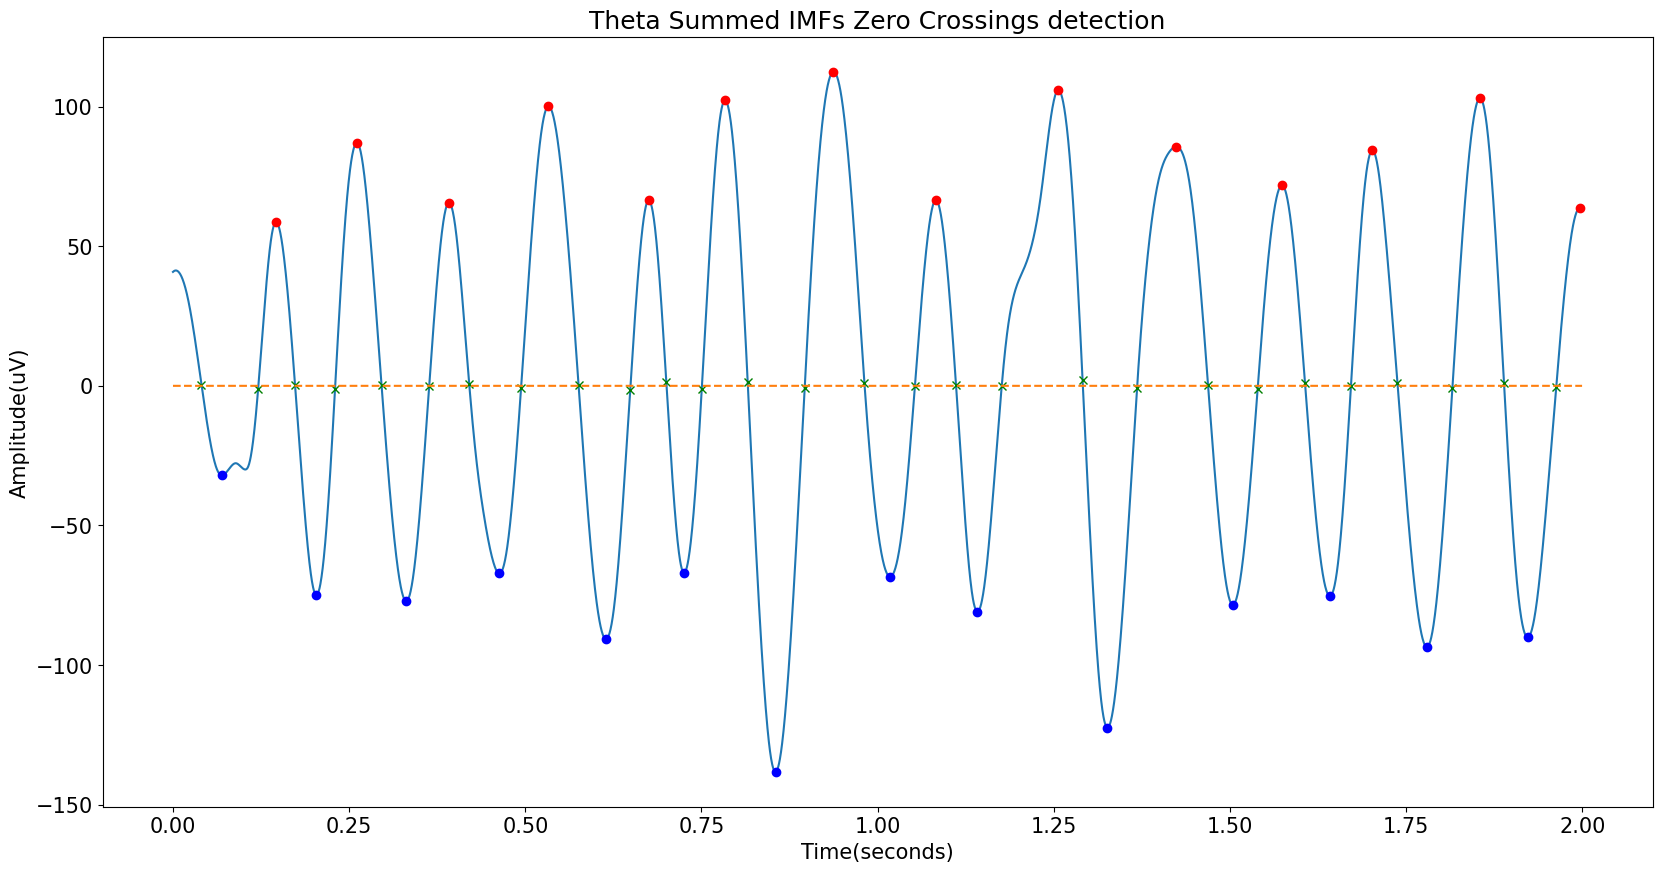

In [44]:
# Parsing Zero-Crossings , Troughs and Peaks

zero_x, troughs, peaks = extrema(imask_thetasig)

# Plotting the zero crossing locations

plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:5000],imask_thetasig[:5000])
plt.plot(seconds[zero_x[zero_x <= 2*s_rate]],imask_thetasig[zero_x[zero_x <= 2*s_rate]], "x",color='green')
plt.plot(seconds[troughs[troughs <= 2*s_rate]],imask_thetasig[troughs[troughs <= 2*s_rate]], "o",color='blue')
plt.plot(seconds[peaks[peaks <= 2*s_rate]],imask_thetasig[peaks[peaks <= 2*s_rate]], "o",color='red')
plt.plot(seconds[0:5000],np.zeros(5000),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('Theta Summed IMFs Zero Crossings detection')
plt.show()

## Parsing individual cycles

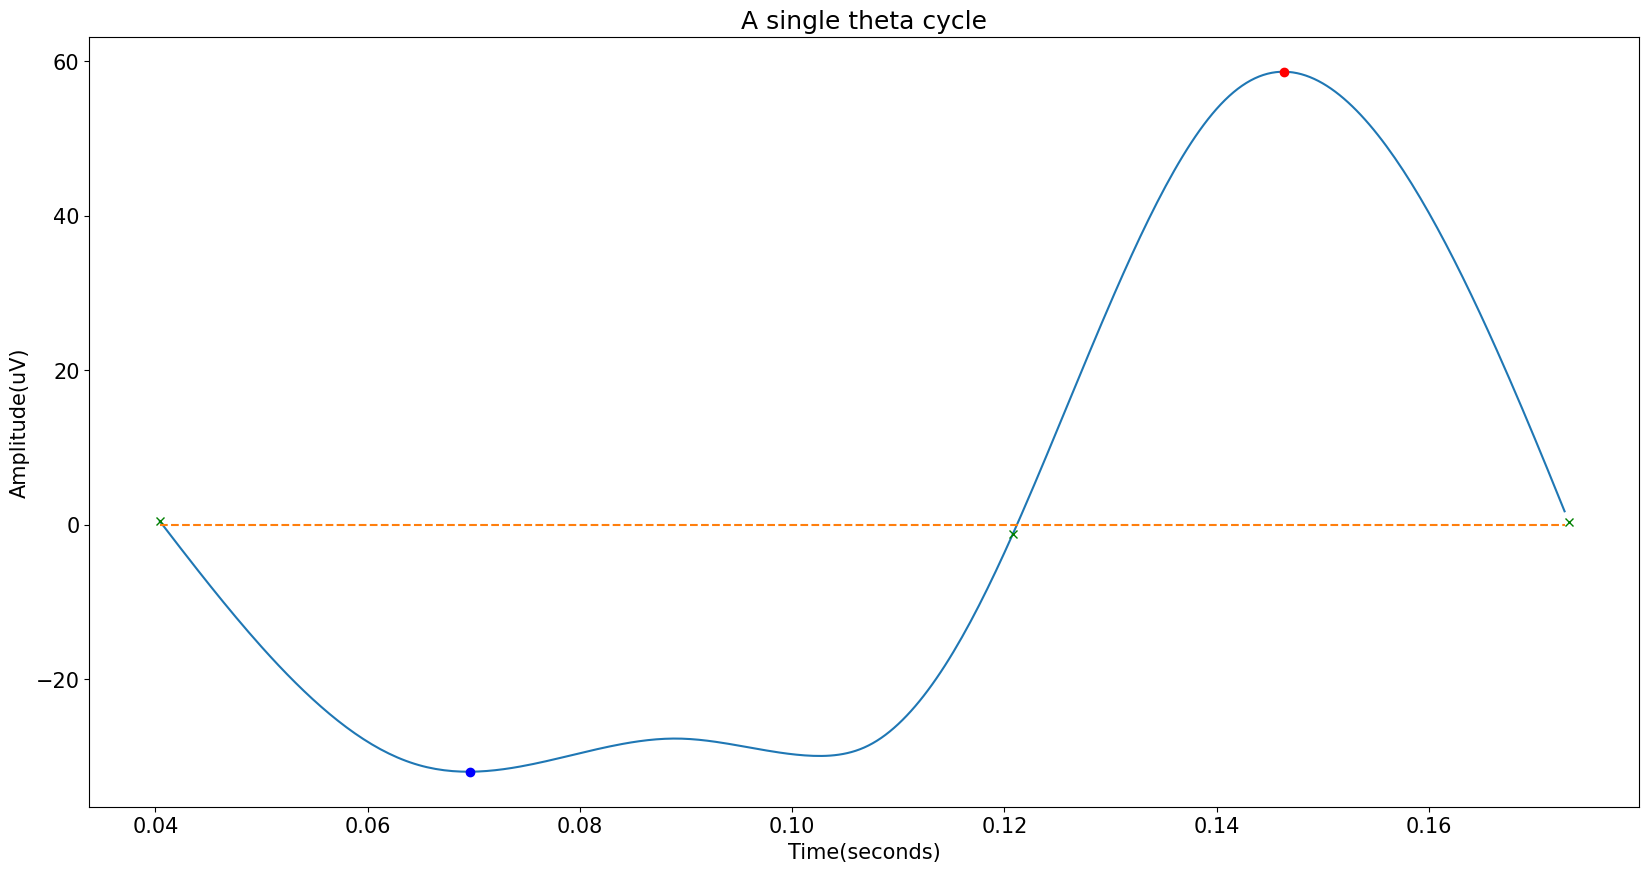

In [45]:
plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[zero_x[0]:zero_x[2]],imask_thetasig[zero_x[0]:zero_x[2]])
plt.plot(seconds[zero_x[:3]],imask_thetasig[zero_x[:3]], "x",color='green')
plt.plot(seconds[troughs[0]],imask_thetasig[troughs[0]], "o",color='blue')
plt.plot(seconds[peaks[0]],imask_thetasig[peaks[0]], "o",color='red')
plt.plot(seconds[zero_x[0]:zero_x[2]],np.zeros(zero_x[2]-zero_x[0]),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('A single theta cycle')
plt.show()

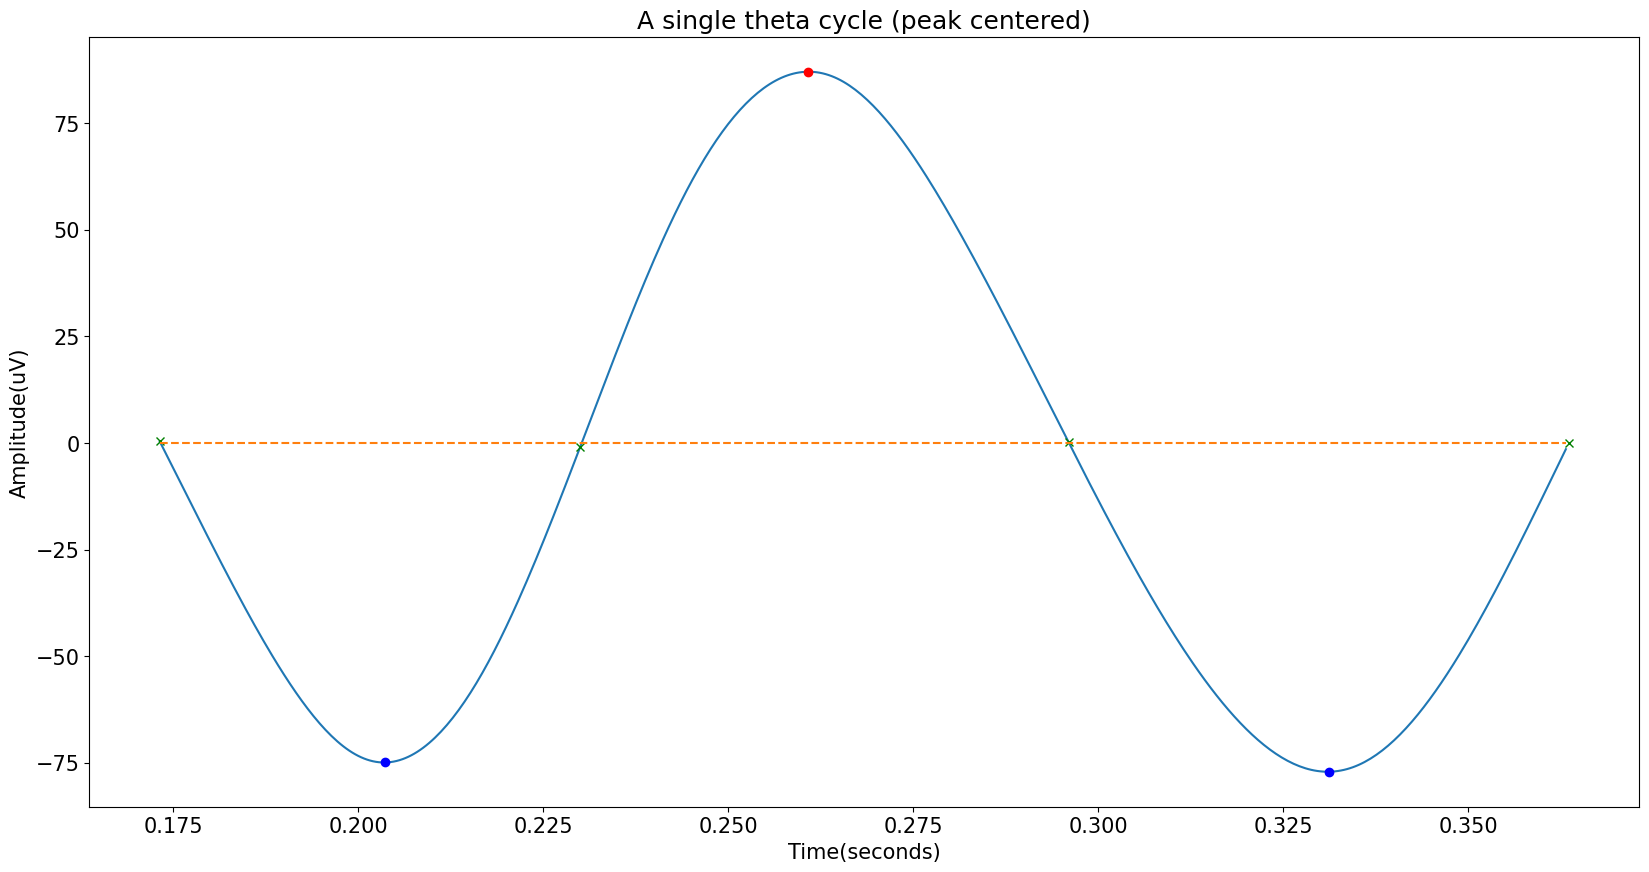

In [61]:
plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[zero_x[2]:zero_x[5]],imask_thetasig[zero_x[2]:zero_x[5]])
plt.plot(seconds[troughs[1:3]],imask_thetasig[troughs[1:3]], "o",color='blue')
plt.plot(seconds[zero_x[2:6]],imask_thetasig[zero_x[2:6]], "x",color='green')

plt.plot(seconds[peaks[1]],imask_thetasig[peaks[1]], "o",color='red')
plt.plot(seconds[zero_x[2]:zero_x[5]],np.zeros(zero_x[5]-zero_x[2]),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('A single theta cycle (peak centered)')
plt.show()


## Grouping cycles together

In [62]:
# Initialize variables
x=lfp
rem_states=states
sample_rate = 2500
frequencies= np.arange(20,141,1)
theta_range=(5,12)

In [63]:
x = np.squeeze(x)
rem_states = np.squeeze(rem_states)

print(x.shape)
print(rem_states.shape)

# Detect REM periods
consecutive_rem_states = get_rem_states(rem_states, sample_rate).astype(int)

if consecutive_rem_states.ndim == 3:
    consecutive_rem_states=np.squeeze(consecutive_rem_states,0)

print(consecutive_rem_states.shape)

# Intiializing variables
# wt_spectrum = []
rem_imf = []
rem_mask_freq = []
instantaneous_phase = []
instantaneous_freq = []
instantaneous_amp = []
sub_theta_sig = np.empty((0,))
theta_peak_sig = np.empty((0,))
cycles = np.empty((0, 5))
rem_dict = {}
sub_dict = rem_dict
good_rem = []
count = 0

# Loop through each REM epoch
for i, rem in enumerate(consecutive_rem_states):
    start = rem[0]
    end = rem[1]+1
    signal = x[start:end]

    # Generate the time-frequency power spectrum
    # print('Generating time-frequency matrix')
    # wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

    # Extraction of IMFs and IMF Frequencies for current REM epoch
    print('Finding Intrinsic Mode Functions')
    imf, mask_freq = emd.sift.iterated_mask_sift(signal,
                                                 mask_0='zc',
                                                 sample_rate=sample_rate,
                                                 ret_mask_freq=True)

    # Extract Instantaneous Phase, Frequencies and Amplitudes of each IMF for current REM epoch
    print('Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF')
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

    # wt_spectrum.append(wavelet_transform)
    rem_imf.append(imf)
    rem_mask_freq.append(mask_freq)
    instantaneous_phase.append(IP)
    instantaneous_freq.append(IF)
    instantaneous_amp.append(IA)

    # Identify sub-theta, theta, and supra-theta frequencies
    sub_theta, theta, _ = tg_split(mask_freq, theta_range)

    if np.any(theta):
        print('Theta frequencies are valid')
        count += 1
        good_rem.append(i)
        sub_dict.setdefault(f'REM {count}', {})
    elif not np.any(theta):
        print(f'No valid theta frequencies for REM {i}')
        continue

    print(f'Processing REM {count} ')

    # Generate the theta signal to detect cycles
    theta_sig = np.sum(imf.T[theta], axis=0)

    # Parse the sub-theta signal of all REM periods into one variable to set amplitude threshold
    sub_theta_sig = np.append(sub_theta_sig, np.sum(imf.T[sub_theta], axis=0))

    # Generate extrema locations and zero crossing on the generated theta signal
    zero_x, trough, peak = extrema(np.sum(imf.T[theta], axis=0))
    print(f'Number of zero crossings, {zero_x.shape}')

    # Create the cycles array for the current REM epoch
    zero_x = np.vstack((zero_x[:-2:2], zero_x[1:-1:2], zero_x[2::2])).T

    size_adjust = np.min([trough.shape[0], zero_x.shape[0], peak.shape[0]])
    zero_x = zero_x[:size_adjust]
    cycle = np.empty((size_adjust, 5))
    cycle[:, [0, 2, 4]] = zero_x
    if trough[0] < peak[0]:
        cycle[:, 1] = trough[:zero_x.shape[0]]
        cycle[:, 3] = peak[:zero_x.shape[0]]
    else:
        cycle[:, 3] = trough[:zero_x.shape[0]]
        cycle[:, 1] = peak[:zero_x.shape[0]]

    broken_cycle = cycle[~np.all(np.diff(cycle, axis=1) > 0, axis=1)]
    broken_cycle_mask = np.diff(broken_cycle, axis=1) > 0

    adjust_condition = np.all(np.all(broken_cycle_mask[1:] == [True, False, False, True],
                                     axis=0) == True)
    adjust_loc = np.where(np.all(np.diff(cycle, axis=1) > 0, axis=1) == False)[0][1:-1]

    fixed_cycle = broken_cycle[1:-1]
    if adjust_condition:
        fixed_cycle[:, 1] = cycle[adjust_loc - 1, 1]
        fixed_cycle[:, 3] = cycle[adjust_loc + 1, 3]
    else:
        fixed_cycle[:, 3] = cycle[adjust_loc - 1, 3]
        fixed_cycle[:, 1] = cycle[adjust_loc + 1, 1]

    cycle = cycle[np.all(np.diff(cycle, axis=1) > 0, axis=1)]
    cycle = np.vstack((cycle, fixed_cycle))
    if trough[0] < peak[0]:
        cycle = np.hstack((cycle[:-1, 1:-1], cycle[1:, :2]))
    else:
        cycle = np.hstack((cycle[:-1, 3].reshape((-1, 1)), cycle[1:, :-1]))
    print(f'Number of cycles, {cycle.shape}')
    print('----------------------------------------------------------------------')
    # Create an array of amplitudes at the peaks
    theta_peak_sig = np.append(theta_peak_sig, theta_sig[cycle[:, 2].astype(int)])
    cycles = np.vstack((cycles, cycle + start))

(27008171,)
(10802,)
(8, 2)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 1 
Number of zero crossings, (1342,)
Number of cycles, (669, 5)
----------------------------------------------------------------------
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 2 
Number of zero crossings, (604,)
Number of cycles, (300, 5)
----------------------------------------------------------------------
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 3 
Number of zero crossings, (2281,)
Number of cycles, (1136, 5)
----------------------------------------------------------------------
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are 

In [64]:
print(f'Number of cycles extracted:{cycles.shape[0]} cycles')

Number of cycles extracted:4693 cycles


## Identification of good theta cycles

In [65]:
upper_diff = np.floor(1000 / np.min(theta_range))
lower_diff = np.floor(1000 / np.max(theta_range))
# A filter mask to omit baad cycles that don't satisfy the cycle duration
diff_mask = np.logical_and(np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) > lower_diff,
                           np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) <= upper_diff)

## Defining the amplitude threshold

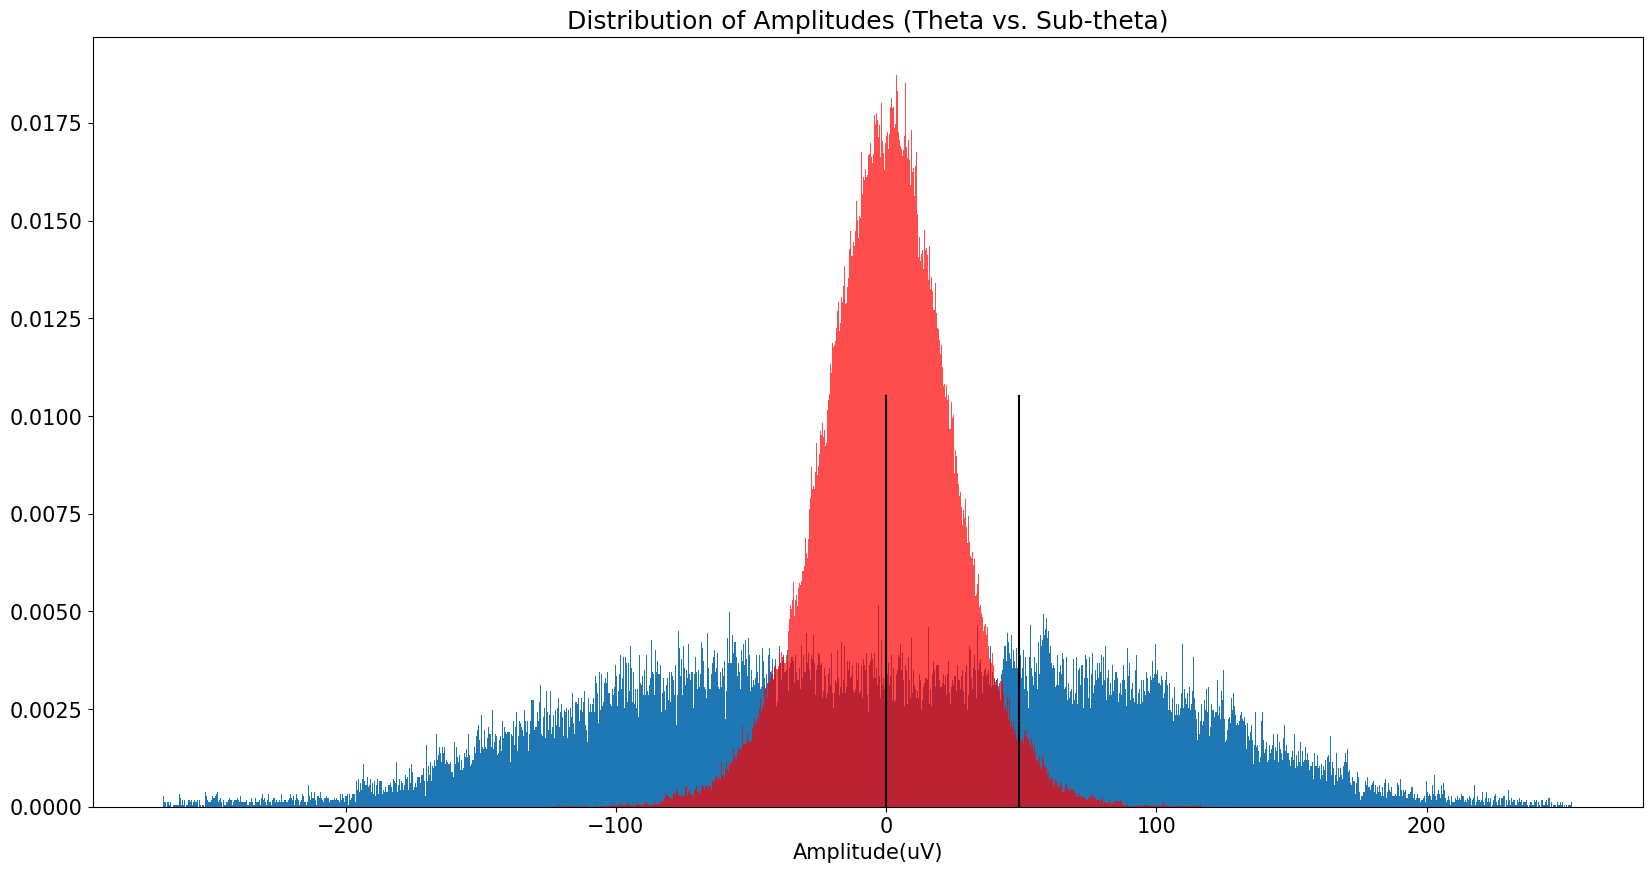

In [66]:
min_peak_amp = 2 * sub_theta_sig.std()

plt.gcf().set_size_inches(20, 10)
plt.hist(theta_sig, bins=2500,density=True)
plt.hist(sub_theta_sig, bins=2500, alpha=0.7,density=True, color='red')
plt.plot(np.zeros(50), np.linspace(0,0.0105,50), color='black')
plt.plot(min_peak_amp*np.ones(50), np.linspace(0,0.0105,50), color='black')

plt.xlabel('Density')
plt.xlabel('Amplitude(uV)')
plt.title('Distribution of Amplitudes (Theta vs. Sub-theta)')
plt.show()

## Applying both the thresholds

In [67]:
peak_mask = theta_peak_sig > min_peak_amp
extrema_mask = np.logical_and(np.squeeze(diff_mask), peak_mask)
theta_cycles=cycles[extrema_mask]
print(f'Number of theta cycles detected:{theta_cycles.shape[0]} out of {cycles.shape[0]} cycles')

Number of theta cycles detected:3875 out of 4693 cycles


# Frequency-Phase Plot

In [68]:
! pip install sails

In [69]:
import sails

## The wavelet transform

In [71]:
# Load the REM states and pick the first REM period

rem_states=get_rem_states(states, s_rate).astype(int)
last_rem=lfp[rem_states[-1,0]:rem_states[-1,1]] # Load the first REM epoch for our example

# Generate the IMFs
imask = emd.sift.iterated_mask_sift(last_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')

# Extract the theta signal
sub_theta, theta, supra_theta = tg_split(imask[1])
theta_sig=np.sum(imask[0].T[theta],axis=0)
supra_theta_sig=np.sum(imask[0].T[supra_theta],axis=0)
sub_theta_sig= np.sum(imask[0].T[sub_theta],axis=0)

In [72]:
# Call the morlet wavelet transform function and generate Morlet wavelet spectograms

frequencies= np.arange(15,141,1)
theta_range=(5,12)
time=len(last_rem)/s_rate
seconds=np.linspace(0,time,len(last_rem))

last_rem_wt= sails.wavelet.morlet(last_rem, freqs=frequencies, sample_rate=sample_rate, ncycles=5,ret_mode='power', normalise=None)
theta_wt= sails.wavelet.morlet(theta_sig, freqs=frequencies, sample_rate=sample_rate, ncycles=5,ret_mode='power', normalise=None)
supra_theta_wt= sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=sample_rate, ncycles=5,ret_mode='power', normalise=None)

TypeError: Length of x (87500) must match number of columns in z (126)

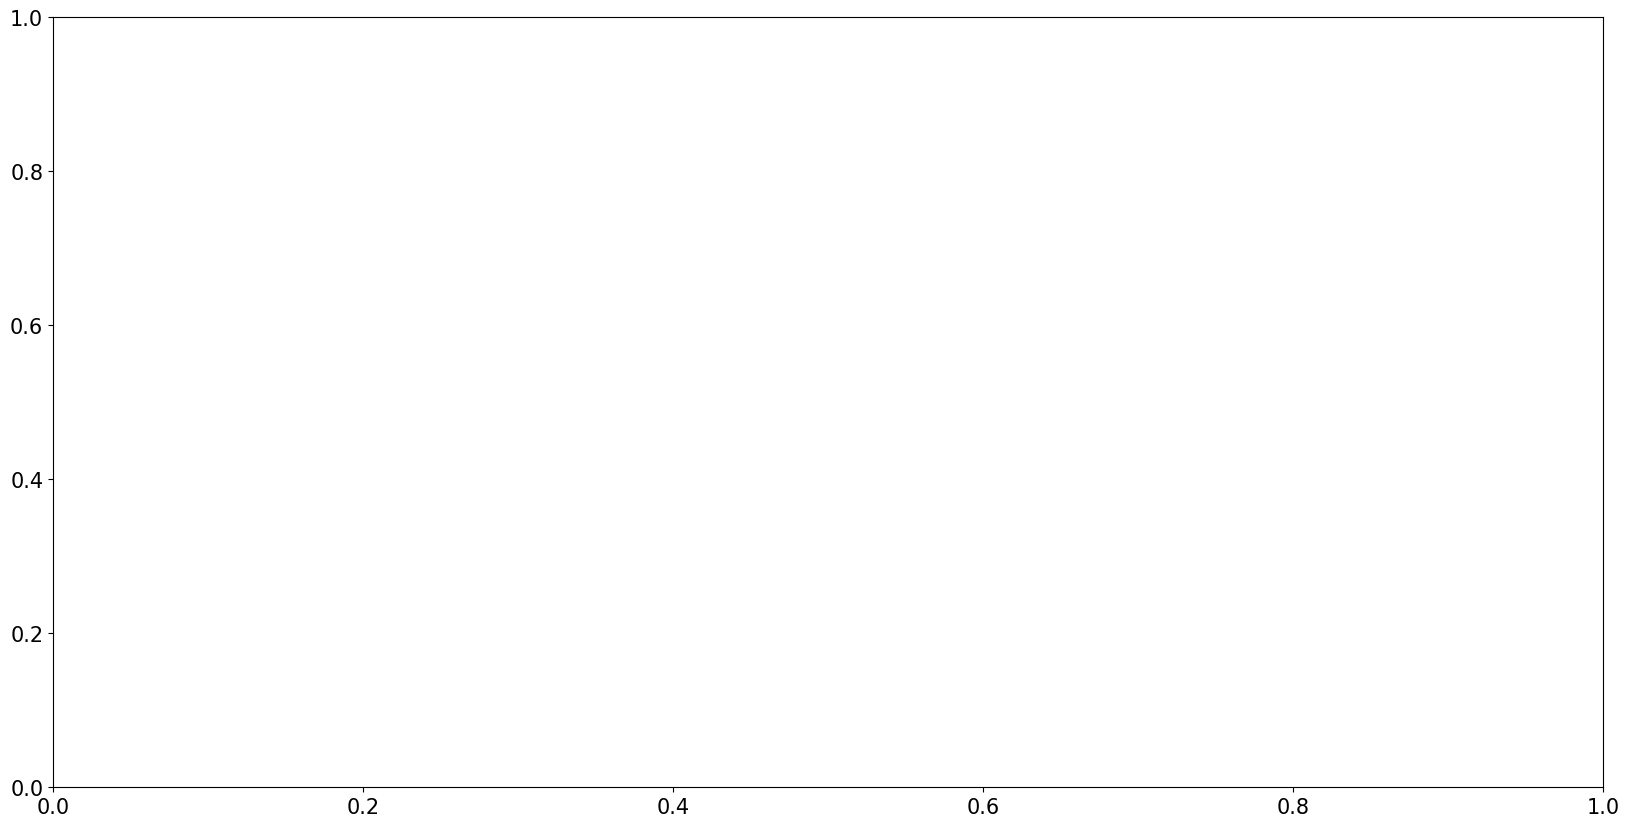

In [78]:
# Normalized Raw Signal Wavelet Transform
plt.gcf().set_size_inches(20, 10)
last_rem_wt=scipy.stats.zscore(last_rem_wt,axis=0) #Z-Score Normalize the dataset
last_rem_wt = np.squeeze(last_rem_wt)
plt.contourf(seconds,frequencies,last_rem_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

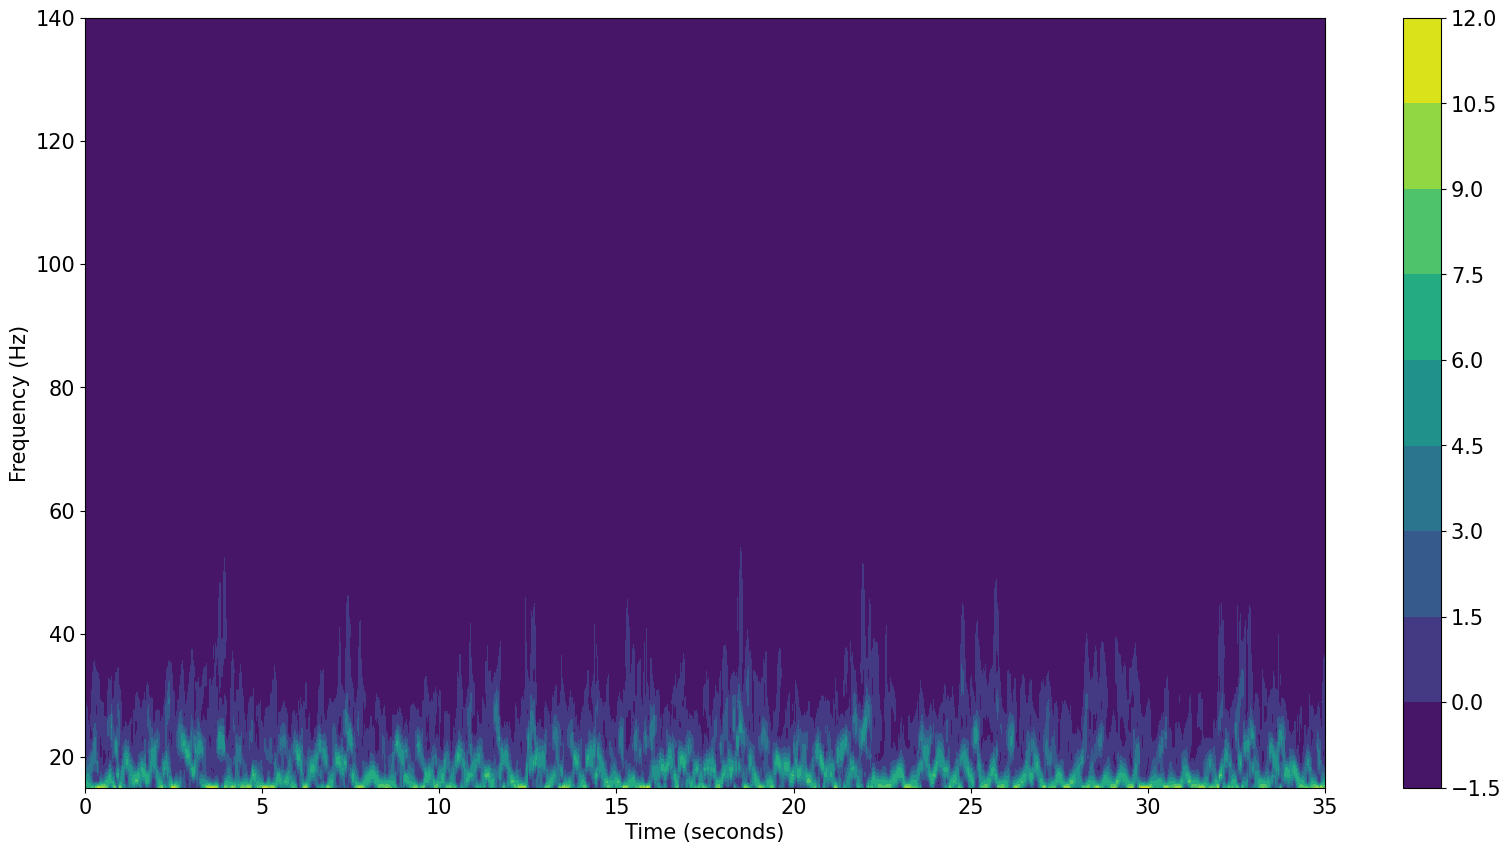

In [79]:
# Normalized Theta Signal Wavelet Transform

plt.gcf().set_size_inches(20, 10)
theta_wt=scipy.stats.zscore(theta_wt,axis=0) #Z-Score Normalize the dataset
plt.contourf(seconds,frequencies,theta_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

Text(0.5, 0, 'Time (seconds)')

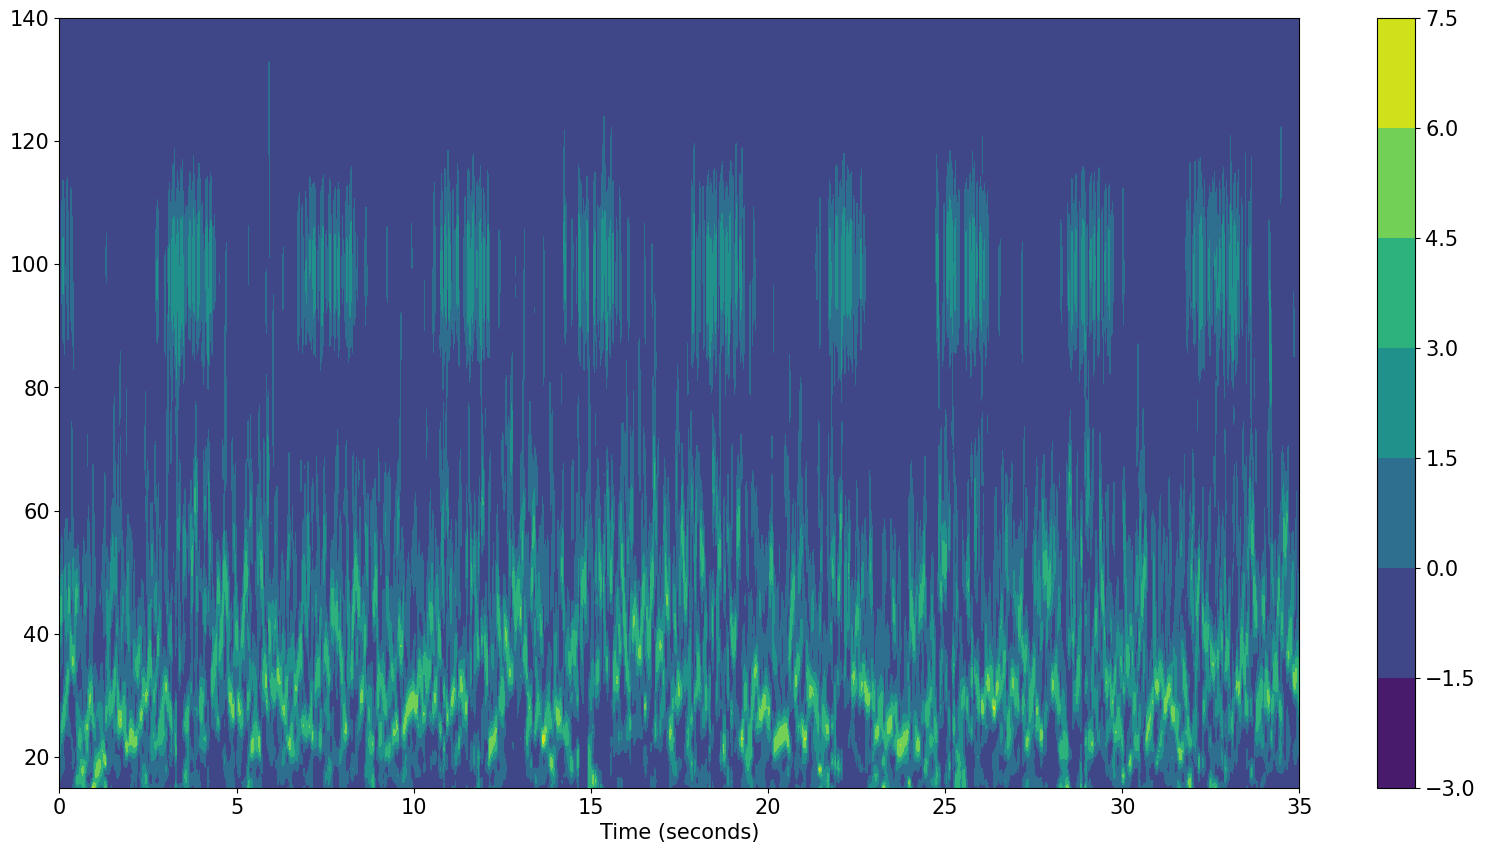

In [80]:
# Normalized Supra-Theta Signal Wavelet Transform

plt.gcf().set_size_inches(20, 10)
supra_theta_wt=scipy.stats.zscore(supra_theta_wt,axis=0) #Z-Score Normalize the dataset
plt.contourf(seconds,frequencies,supra_theta_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')

## Building an indexed dataset from a time-frequency matrix

In [81]:
# Define a morlet wavelet transform function
def morlet_wt(x, sample_rate, frequencies=np.arange(1, 200, 1), n=5, mode='complex'):
    """
        Compute the Morlet Wavelet Transform of a signal.

        Parameters: x (numpy.ndarray): The input signal for which the Morlet Wavelet Transform is computed.
        sample_rate (int or float): The sampling rate of the input signal. frequencies (numpy.ndarray, optional): An
        array of frequencies at which to compute the wavelet transform. Default is a range from 1 to 200 Hz with a
        step of 1 Hz. n (int, optional): The number of cycles of the Morlet wavelet. Default is 5. mode (str,
        optional): The return mode for the wavelet transform. Options are 'complex' (default),'amplitude', and 'power'.

        Returns:
        numpy.ndarray: The Morlet Wavelet Transform of the input signal.

        Notes: - This function computes the Morlet Wavelet Transform of a given signal. - The wavelet transform is
        computed at specified frequencies. - The number of cycles for the Morlet wavelet can be adjusted using the
        'n' parameter. - The result can be returned in either complex or magnitude form either as amplitude or power,
        as specified by the 'mode' parameter.
    """
    wavelet_transform = sails.wavelet.morlet(x, freqs=frequencies, sample_rate=sample_rate, ncycles=n,
                                             ret_mode=mode, normalise=None)
    return wavelet_transform

In [86]:
def get_cycles_data(x, rem_states, sample_rate, frequencies, theta_range=(5, 12)):
    """
    Generate a nested dictionary containing extracted data and desired metadata of each REM epochs in the input sleep
    signal

    Parameters:
    x (numpy.ndarray): The input 1D sleep signal.
    rem_states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.
    theta_range (tuple, optional): A tuple defining the theta frequency range (lower, upper).
            Default is (5, 12).

    Returns:
    rem_dict: A nested dictionary of extracted signal data and signal source metadata

    Notes:
    - The dictionary output structure comes out as below:
        |----REM 1
        |    |----start_end:
        |    |----IMFs:
        |    |----IMF Frequencies:
        |    |----Instantaneous Phases:
        |    |----Instantaneous Frequencies:
        |    |----Instantaneous Amplitudes:
        |    |----Cycles:
        |----REM (...)
        |    |--------(...)
    """

    # Squeezing dimensions
    x = np.squeeze(x)
    rem_states = np.squeeze(rem_states)

    print(x.shape)
    print(rem_states.shape)

    # Detect REM periods
    consecutive_rem_states = get_rem_states(rem_states, sample_rate).astype(int)

    if consecutive_rem_states.ndim == 3:
        consecutive_rem_states=np.squeeze(consecutive_rem_states,0)

    print(consecutive_rem_states.shape)

    # Intiializing variables
    wt_spectrum = []
    rem_imf = []
    rem_mask_freq = []
    instantaneous_phase = []
    instantaneous_freq = []
    instantaneous_amp = []
    sub_theta_sig = np.empty((0,))
    theta_peak_sig = np.empty((0,))
    cycles = np.empty((0, 5))
    rem_dict = {}
    sub_dict = rem_dict
    good_rem = []
    count = 0
    # Loop through each REM epoch
    for i, rem in enumerate(consecutive_rem_states):
        start = rem[0]
        end = rem[1]+1
        signal = x[start:end]

        # Extraction of IMFs and IMF Frequencies for current REM epoch
        print('Finding Intrinsic Mode Functions')
        imf, mask_freq = emd.sift.iterated_mask_sift(signal,
                                                 mask_0='zc',
                                                 sample_rate=sample_rate,
                                                 ret_mask_freq=True)

        # Extract Instantaneous Phase, Frequencies and Amplitudes of each IMF for current REM epoch
        print('Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF')
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

        # Identify sub-theta, theta, and supra-theta frequencies
        sub_theta, theta, supra_theta = tg_split(mask_freq, theta_range)

        if np.any(theta):
            print('Theta frequencies are valid')
            count += 1
            good_rem.append(i)
            sub_dict.setdefault(f'REM {count}', {})
        elif not np.any(theta):
            print(f'No valid theta frequencies for REM {i}')
            continue

        print(f'Processing REM {count} ')

        # Generate the time-frequency power spectrum
        print('Generating time-frequency matrix')
        wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        # print('Generating time-frequency matrix')
        # if wavelet =='theta':
        #     wavelet_transform = morlet_wt(np.sum(imf.T[theta], axis=0),
        #                                   sample_rate,
        #                                   frequencies,
        #                                   mode='amplitude')
        # elif wavelet == 'gamma':
        #     wavelet_transform = morlet_wt(np.sum(imf.T[supra_theta], axis=0),
        #                                   sample_rate,
        #                                   frequencies,
        #                                   mode='amplitude')
        # else:
        #     wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        wt_spectrum.append(wavelet_transform)
        rem_imf.append(imf)
        rem_mask_freq.append(mask_freq)
        instantaneous_phase.append(IP)
        instantaneous_freq.append(IF)
        instantaneous_amp.append(IA)

        # Generate the theta signal to detect cycles
        theta_sig = np.sum(imf.T[theta], axis=0)

        # Parse the sub-theta signal of all REM periods into one variable to set amplitude threshold
        sub_theta_sig = np.append(sub_theta_sig, np.sum(imf.T[sub_theta], axis=0))

        # Generate extrema locations and zero crossing on the generated theta signal
        zero_x, trough, peak = extrema(np.sum(imf.T[theta], axis=0))
        print(f'Number of zero crossings, {zero_x.shape}')

        # Create the cycles array for the current REM epoch
        zero_x = np.vstack((zero_x[:-2:2], zero_x[1:-1:2], zero_x[2::2])).T

        size_adjust = np.min([trough.shape[0], zero_x.shape[0], peak.shape[0]])
        zero_x = zero_x[:size_adjust]
        cycle = np.empty((size_adjust, 5))
        cycle[:, [0, 2, 4]] = zero_x
        if trough[0] < peak[0]:
            cycle[:, 1] = trough[:zero_x.shape[0]]
            cycle[:, 3] = peak[:zero_x.shape[0]]
        else:
            cycle[:, 3] = trough[:zero_x.shape[0]]
            cycle[:, 1] = peak[:zero_x.shape[0]]

        broken_cycle = cycle[~np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        broken_cycle_mask = np.diff(broken_cycle, axis=1) > 0

        adjust_condition = np.all(np.all(broken_cycle_mask[1:] == [True, False, False, True],
                                         axis=0) == True)
        adjust_loc = np.where(np.all(np.diff(cycle, axis=1) > 0, axis=1) == False)[0][1:-1]

        fixed_cycle = broken_cycle[1:-1]
        if adjust_condition:
            fixed_cycle[:, 1] = cycle[adjust_loc - 1, 1]
            fixed_cycle[:, 3] = cycle[adjust_loc + 1, 3]
        else:
            fixed_cycle[:, 3] = cycle[adjust_loc - 1, 3]
            fixed_cycle[:, 1] = cycle[adjust_loc + 1, 1]

        cycle = cycle[np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        cycle = np.vstack((cycle, fixed_cycle))
        if trough[0] < peak[0]:
            cycle = np.hstack((cycle[:-1, 1:-1], cycle[1:, :2]))
        else:
            cycle = np.hstack((cycle[:-1, 3].reshape((-1, 1)), cycle[1:, :-1]))
        print(f'Number of cycles, {cycle.shape}')
        # Create an array of amplitudes at the peaks
        theta_peak_sig = np.append(theta_peak_sig, theta_sig[cycle[:, 2].astype(int)])
        cycles = np.vstack((cycles, cycle + start))

    # Set the minimum amplitude threshold and discard unsatisfactory theta peaks
    min_peak_amp = 2 * sub_theta_sig.std()
    peak_mask = theta_peak_sig > min_peak_amp

    # Set the frequency threshold and discard and unsatisfactory difference between trough pairs
    upper_diff = np.floor(1000 / np.min(theta_range))
    lower_diff = np.floor(1000 / np.max(theta_range))
    diff_mask = np.logical_and(np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) > lower_diff,
                               np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) <= upper_diff)

    # Create a boolean mask that satisfy both the frequency and amplitude threshold criteria
    extrema_mask = np.logical_and(np.squeeze(diff_mask), peak_mask)

    # Pass the boolean mask on the cycles array to discard any unsatisfactory cycles
    cycles = cycles[extrema_mask]

    # Place outputs in a nested dictionary
    for j, rem in enumerate(rem_dict.values()):
        good_rem_states = consecutive_rem_states[good_rem]
        rem['start-end'] = good_rem_states[j]
        rem['wavelet_transform'] = wt_spectrum[j]
        rem['IMFs'] = rem_imf[j]
        rem['IMF_Frequencies'] = rem_mask_freq[j]
        rem['Instantaneous Phases'] = instantaneous_phase[j]
        rem['Instantaneous Frequencies'] = instantaneous_freq[j]
        rem['Instantaneous Amplitudes'] = instantaneous_amp[j]
        cycles_mask = (cycles > good_rem_states[j, 0]) & (cycles < good_rem_states[j, 1])
        cycles_mask = np.all(cycles_mask == True, axis=1)
        if cycles[cycles_mask].size == 0:
            rem_cycles = np.zeros((1, 5)).astype(int) # Empty Cycles Array (none of the cycles passed our thresholds)
        else:
            rem_cycles = cycles[cycles_mask].astype(int)
        rem['Cycles'] = rem_cycles

    return rem_dict

In [87]:
# To demonstrate one example let's extract the cycles of the first REM period
rem_dict=get_cycles_data(lfp,states,s_rate,frequencies)

(27008171,)
(10802,)
(8, 2)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 1 
Generating time-frequency matrix
Number of zero crossings, (1342,)
Number of cycles, (669, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 2 
Generating time-frequency matrix
Number of zero crossings, (604,)
Number of cycles, (300, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 3 
Generating time-frequency matrix
Number of zero crossings, (2281,)
Number of cycles, (1136, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 4 
Generating time-frequency matrix
Number of zero crossings, (864,)
Number of cycles, (428, 

In [89]:
first_rem_cycles=rem_dict['REM 1']['Cycles']
print(first_rem_cycles.shape)
first_rem_wt=rem_dict['REM 1']['wavelet_transform']
print(first_rem_wt.shape)

(581, 5)
(126, 207501)
(581, 5)
(126, 207501)


Text(0.5, 1.0, 'Single cycle Supra-theta Signal TF Matrix')

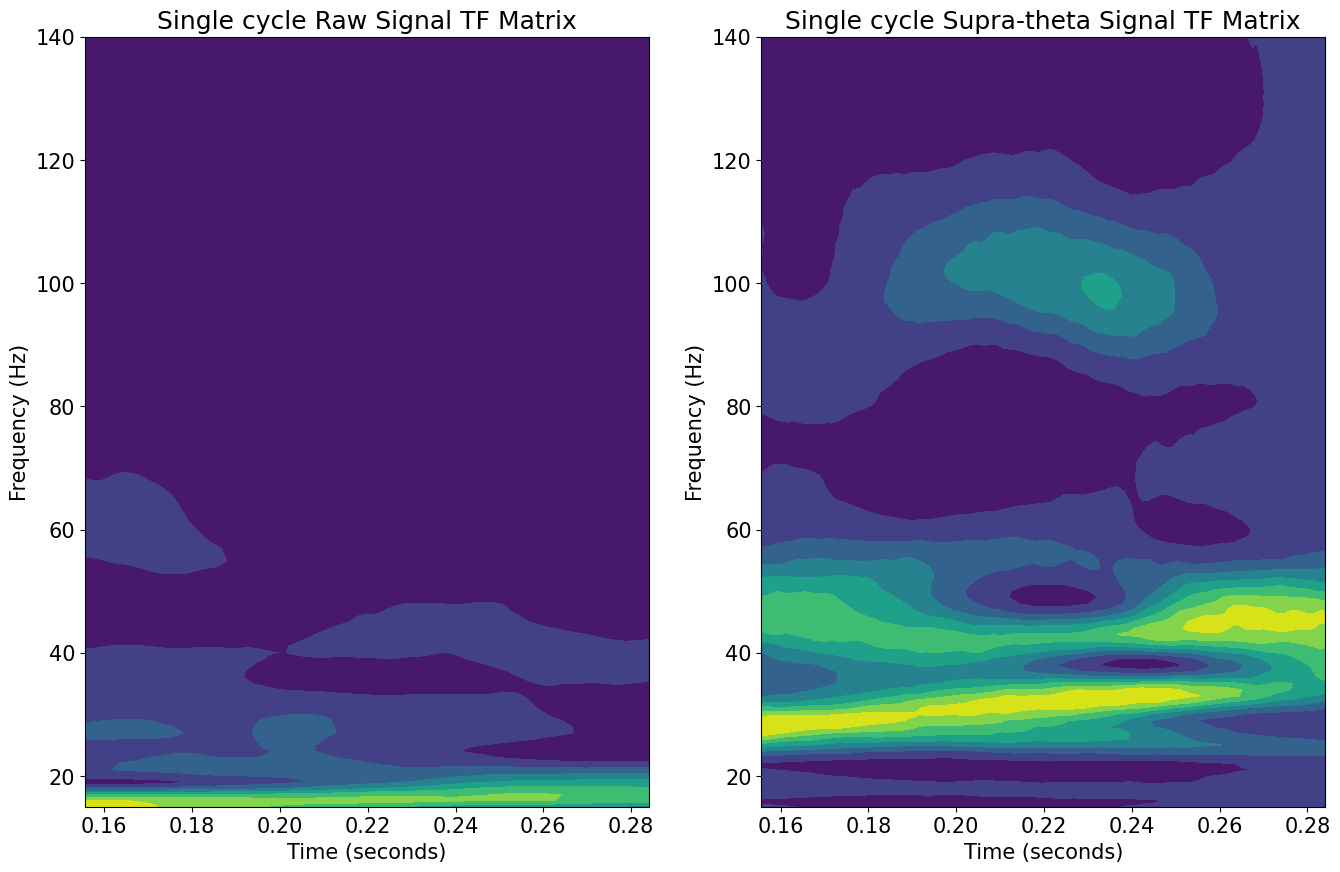

In [90]:
# Plotting Time Frequency Matrix of a single cycle of the Raw Signal Wavelet Transform
single_cycle=first_rem_cycles[0]-rem_dict['REM 1']['start-end'][0]
fig,ax=plt.subplots(1,2,figsize=(16,10))
plt.rcParams.update({'font.size': 15})
ax[0].contourf(seconds[single_cycle[0]:single_cycle[-1]+1],frequencies,first_rem_wt[:,single_cycle[0]:single_cycle[-1]+1])
ax[0].set_xlabel(r'Time (seconds)')
ax[0].set_ylabel(r'Frequency (Hz)')
ax[0].set_title('Single cycle Raw Signal TF Matrix')
ax[1].contourf(seconds[single_cycle[0]:single_cycle[-1]+1],frequencies,supra_theta_wt[:,single_cycle[0]:single_cycle[-1]+1])
ax[1].set_xlabel(r'Time (seconds)')
ax[1].set_ylabel(r'Frequency (Hz)')
ax[1].set_title('Single cycle Supra-theta Signal TF Matrix')

In [91]:
# Binning samples into respective phase bins

# Define the function to bin time samples into phase segments
def bin_tf_to_fpp(x, power, bin_count):
    """
       Bin time-frequency power data into Frequency Phase Power (FPP) plots using specified time intervals of cycles.

       Parameters:
       x (numpy.ndarray): A 1D or 2D array specifying time intervals of cycles for binning.
           - If 1D, it represents a single time interval [start, end].
           - If 2D, it represents multiple time intervals, where each row is [start, end].
       power (numpy.ndarray): The time-frequency power spectrum data to be binned.
       bin_count (int): The number of bins to divide the time intervals into.

       Returns:
       fpp(numpy.ndarray): Returns FPP plots

       Notes:
       - This function takes time-frequency power data and divides it into FPP plots based on specified
         time intervals.
       - The 'x' parameter defines the time intervals, which can be a single interval or multiple intervals.
       - The 'power' parameter is the time-frequency power data to be binned.
       - The 'bin_count' parameter determines the number of bins within each time interval.
       """

    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp

In [92]:
FPP_cycles=bin_tf_to_fpp(first_rem_cycles[:,[0,-1]]-rem_dict['REM 1']['start-end'][0],first_rem_wt,19)
print(f'{FPP_cycles.shape[0]} cycles of {FPP_cycles.shape[1:]} arrays')

581 cycles of (126, 19) arrays


Text(0.5, 1.0, 'Cycle 2')

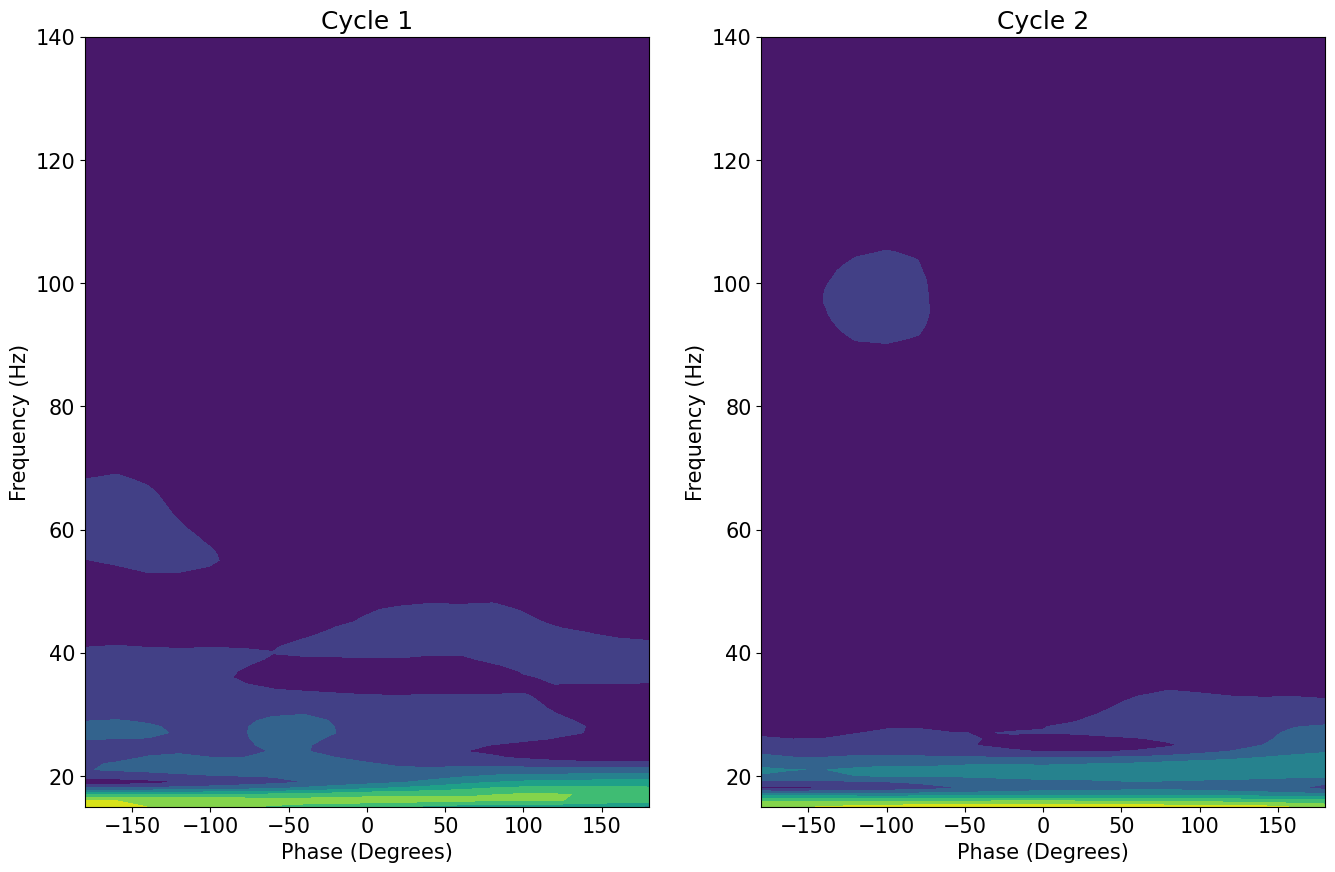

In [93]:
# Plotting the FPP plots of the first two cycles
# Take note of the Phase axis
angles=np.linspace(-180,180,19)
fig,ax=plt.subplots(1,2,figsize=(16,10))
plt.rcParams.update({'font.size': 15})
ax[0].contourf(angles,frequencies,FPP_cycles[0])
ax[0].set_xlabel(r'Phase (Degrees)')
ax[0].set_ylabel(r'Frequency (Hz)')
ax[0].set_title('Cycle 1')
ax[1].contourf(angles,frequencies,FPP_cycles[1])
ax[1].set_xlabel(r'Phase (Degrees)')
ax[1].set_ylabel(r'Frequency (Hz)')
ax[1].set_title('Cycle 2')